## Analysis of scraped data form KV.ee

### Import of packages

In [122]:
import os # this is needed atleast for me because otherwise reprojection of coordinate systems does not work. 
os.environ['PROJ_DATA'] = r'C:\Users\Dan\micromamba\envs\geopython2025\Library\share\proj'
os.environ['PROJ_LIB'] = r'C:\Users\\Dan\micromamba\envs\geopython\Library\share\proj'

In [123]:
from itertools import chain
import numpy as np
import pandas as pd
from tqdm import tqdm
import geopandas as gpd
from shapely.geometry import Point, box
from shapely.ops import nearest_points
from scipy.spatial import cKDTree
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import matplotlib.path as mpltPath
from matplotlib.colors import ListedColormap, BoundaryNorm
import seaborn as sns
import contextily as ctx
import mapclassify
from mapclassify import NaturalBreaks
import networkx as nx
from networkx import ego_graph
import osmnx as ox
import libpysal
from libpysal.weights import KNN, DistanceBand
from esda.moran import Moran, Moran_BV
from spreg import ML_Lag, ML_Error
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GroupKFold
from sklearn.metrics import (
    mean_squared_error, 
    r2_score, 
    mean_absolute_error,
    mean_absolute_percentage_error,
    classification_report, 
    confusion_matrix, 
    accuracy_score,
    cohen_kappa_score)
tqdm.pandas()

# Data setup

In [13]:
# Tallinn
df = pd.read_csv("C:/Users/Dan/Documents/GitHub/KV-scraper-SAT/Cleaned_csvs/listings_cleaned_tallinn.csv", sep=";") 
gdf_rent = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs="EPSG:4326")
gdf_rent = gdf_rent.to_crs(epsg=3301) # reprojecting the data into the Estonian national coordinate system. So from a geographic coordinate system to a projected coordinate system


In [ ]:
#gdf_rent

## OSM download

### OSM roads downlad

In [3]:
# Defining the study area
place_name = "Tallinn, Estonia"
gdf_place = ox.geocode_to_gdf(place_name) # queries OpenStreetMap service to find the geographical boundary polygon of Tallinn city
polygon = gdf_place.geometry.iloc[0] # extracts the polygon

In [4]:
# Downloading the streetnetwork form OpenStreetMap
G = ox.graph_from_polygon(polygon, network_type='walk') # downloads the street network that is inside the polygon
G = ox.project_graph(G, to_crs='EPSG:3301')  # reprojecting the data into the Estonian national coordinate system 

### OSM services download

In [ ]:
# Getting all the tags that are classified as amenities form OpenStreetmaps data that are inside the study area
tags_amenity = {"amenity": True}
amenity = ox.features_from_polygon(polygon, tags_amenity)
amenity = amenity.to_crs(gdf_rent.crs)

In [ ]:
# Since some of these POI geometries are points and some are polygons we will split them for cleaning
amenity_points = amenity[amenity.geometry.type == "Point"]
amenity_polygons = amenity[amenity.geometry.type.isin(["Polygon", "MultiPolygon"])]

In [ ]:
# Turning polygon geometries into centroids
amenity_polygons_centroids = amenity_polygons.copy()
amenity_polygons_centroids["geometry"] = amenity_polygons_centroids.geometry.centroid

In [ ]:
# Combining the data that were points and the data that were polygons but were turned into points
amenity_combined = pd.concat([amenity_points, amenity_polygons_centroids])
amenity_combined = amenity_combined.reset_index(drop=True)

In [ ]:
# Getting all the tags that are classified as shops and leisure form OpenStreetmaps data that are inside the study area
tags_shop = {"shop": True}
tags_leisure = {"leisure": True}
shops = ox.features_from_polygon(polygon, tags_shop)
leisure = ox.features_from_polygon(polygon, tags_leisure)
# Matching the CRS (coordinate referece system)
shops = shops.to_crs(gdf_rent.crs)
leisure = leisure.to_crs(gdf_rent.crs)

In [ ]:
# Shops
shops_points = shops[shops.geometry.type == "Point"]
shops_polygons = shops[shops.geometry.type.isin(["Polygon", "MultiPolygon"])]

# Leisure
leisure_points = leisure[leisure.geometry.type == "Point"]
leisure_polygons = leisure[leisure.geometry.type.isin(["Polygon", "MultiPolygon"])]

In [ ]:
# Shops
shops_polygons_centroids = shops_polygons.copy()
shops_polygons_centroids["geometry"] = shops_polygons_centroids.geometry.centroid

# Leisure
leisure_polygons_centroids = leisure_polygons.copy()
leisure_polygons_centroids["geometry"] = leisure_polygons_centroids.geometry.centroid

In [ ]:
# Shops
shops_combined = pd.concat([shops_points, shops_polygons_centroids]).reset_index(drop=True)

# Leisure
leisure_combined = pd.concat([leisure_points, leisure_polygons_centroids]).reset_index(drop=True)

## Osm data cleaning

#### Cleaning amenities data

In [ ]:
# Calculating the proportion of nonmissing values per column
non_missing_ratio = amenity_combined.notna().mean()

# Keeping only columns with at least 20% data
cols_keep = non_missing_ratio[non_missing_ratio >= 0.2].index
amenity_reduced = amenity_combined[cols_keep]
print(list(amenity_reduced.columns))

In [ ]:
amenity_cleaned = amenity_reduced.drop(columns=["access","capacity","parking_space"]) # removing backrest aswell because that is not useful at all

In [ ]:
amenity_cleaned[["geometry", "amenity"]].isna().sum() # check for missing values.

In [ ]:
# amenities that are likely to influence rent prices
important_amenities = [
    # education
    "school", "university", "college", "kindergarten", "childcare", "training", "language_school",
    # health
    "pharmacy", "hospital", "clinic", "doctors", "dentist", 
    # admin
    "atm", "bank", "post_office", "courthouse", "townhall",
    # transport
    "parking", "parking_space", "bicycle_parking",
    "charging_station", "fuel", "taxi", "bus_station",
    # leisure
    "restaurant", "cafe", "bar", "pub", "fast_food", "cinema", "theatre",
    "arts_centre", "concert_hall", "nightclub",
    # public
    "community_centre", "social_facility", "library", "marketplace", "public_building",
    "coworking_space", "events_venue",
    # safety
    "police", "fire_station",
    # utilities
    "post_box", "parcel_locker", "recycling", "waste_disposal", "drinking_water"
]

In [ ]:
amenity_clean = amenity_cleaned[amenity_cleaned["amenity"].isin(important_amenities)].reset_index(drop=True)


In [ ]:
pd.set_option("display.max_rows", None)
print(amenity_clean["amenity"].value_counts())

In [ ]:
pd.reset_option("display.max_rows")

#### Cleaning shops data

In [ ]:
# Calculating the proportion of nonmissing values per column
non_missing_ratio_shops = shops_combined.notna().mean()

# Keeping only columns with at least 20% data
cols_keep_shops = non_missing_ratio_shops[non_missing_ratio_shops >= 0.2].index
shops_reduced = shops_combined[cols_keep_shops].copy()
print(list(shops_reduced.columns))

In [ ]:
shops_reduced[['geometry', 'name', 'opening_hours', 'shop', 'wheelchair', 'addr:housenumber', 'addr:street', 'check_date', 'payment:credit_cards', 'payment:debit_cards', 'phone', 'website', 'addr:city', 'level', 'addr:floor']].isna().sum() # check for missing values.
# looking to see if these fields could be valuable

In [ ]:
shops_clean = shops_reduced.drop(columns=['name', 'opening_hours', 'wheelchair', 'addr:housenumber', 'addr:street', 'check_date', 'payment:credit_cards', 'payment:debit_cards', 'phone', 'website', 'addr:city', 'level', 'addr:floor']) 
# removing other data. doesn't seem useful

In [ ]:
shops_clean

In [ ]:
weird_shops = ["yes", "no", "vacant"]  # basically NaN values
shops_clean = shops_clean[~shops_clean["shop"].isin(weird_shops)]

In [ ]:
shop_counts = shops_clean["shop"].value_counts()

# Keeping shop types that appear at least 3 times
shops_clean = shops_clean[shops_clean["shop"].isin(shop_counts[shop_counts >= 3].index)]

In [ ]:
pd.set_option("display.max_rows", None)
print(shops_clean["shop"].value_counts()) 

In [ ]:
pd.reset_option("display.max_rows")

#### Cleaning leisure data

In [ ]:
# Calculating the proportion of nonmissing values per column
non_missing_ratio_leisure = leisure_combined.notna().mean()

# Keeping only columns with at least 20% data
cols_keep_leisure = non_missing_ratio_leisure[non_missing_ratio_leisure >= 0.2].index
leisure_reduced = leisure_combined[cols_keep_leisure].copy()
print(list(leisure_reduced.columns))

In [ ]:
leisure_reduced[['geometry','leisure', 'sport', 'garden:type']].isna().sum() # check for missing values.
# looking to see if these fields could be valuable

In [ ]:
leisure_clean = leisure_reduced.drop(columns=[ 'sport', 'garden:type']) # removing other data. doesn't seem useful

In [ ]:
pd.set_option("display.max_rows", None)
print(leisure_clean["leisure"].value_counts()) 

In [ ]:
pd.reset_option("display.max_rows")

In [ ]:
# this data requires no further cleaning 

## Osm data aggregation

#### Aggregating amenities data

In [ ]:
# making a dictionary for amenity groups
amenity_categories = {
    "early_childhood": ["kindergarten", "childcare"],
    "primary_secondary": ["school"], 
    "higher_education": ["university", "college"],
    "supplementary_education": ["training", "language_school"],
    
    "healthcare": ["pharmacy", "clinic", "hospital", "doctors", "dentist"],
    
    "finance_admin": ["atm", "bank", "courthouse", "post_office", "townhall"],
    
    "transport": ["bus_station", "taxi", "fuel", "charging_station", "police", "fire_station", "bicycle_rental"],
    
    "parking": ["parking", "parking_space", "bicycle_parking"],
    
    "food_drink": ["restaurant", "cafe", "fast_food", "bar", "pub", "marketplace"],

    "community_social": ["community_centre", "social_facility", "library", "coworking_space","public_building", "events_venue", "arts_centre", "theatre", "concert_hall", "nightclub", "cinema"],
    
    "services_utilities": ["recycling", "waste_disposal", "drinking_water", "post_box", "parcel_locker"]}

In [ ]:
amenity_to_category = {
    amenity: category
    for category, amenities in amenity_categories.items()
    for amenity in amenities
}

In [ ]:
# Function to map an amenity to its group
amenity_clean["category"] = amenity_clean["amenity"].map(amenity_to_category)


In [ ]:
amenity_clean

In [ ]:
print(amenity_clean["category"].value_counts(dropna=False))

#### Aggregating shops data

In [ ]:
shop_categories = {
    "clothing": [
        "clothes", "shoes", "jewelry", "bag", "tailor", "second_hand",
        "fashion_accessories", "leather", "watches", 'fabric'],

    "food_grocery": [
        "supermarket", "bakery", "butcher", "greengrocer", "convenience", "alcohol",
        "wine", "cheese", "pastry", "confectionery", "coffee", "chocolate",
        "deli", "tea", "nuts", "seafood", "dairy", "spices", "beverages"],

    "health_beauty": [
        "hairdresser", "beauty", "optician", "medical_supply", "e-cigarette",
        "cosmetics", "massage", "perfumery", "tattoo", "chemist",
        "nutrition_supplements", "cannabis", "pet_grooming"],

    "home_furniture": [
        "furniture", "appliance", "doityourself", "hardware", "bed",
        "interior_decoration", "kitchen", "houseware", "bathroom_furnishing",
        "flooring", "lighting", "doors", "fireplace", "curtain",
        "window_blind", "paint", "tiles", "glaziery", "household_linen"],

    "electronics": [
        "electronics", "computer", "communication",
        "mobile_phone", "electrical", "hifi", "radiotechnics", "video_games"],

    "sports_leisure": [
        "sports", "toys", "fishing",
        "outdoor", "hunting", "music", "musical_instrument",
        "photo", "art", "anime", "party"],

    "vehicles": [
        "car", "car_repair", "car_parts", "bicycle", "tyres",
        "motorcycle", "motorcycle_repair", "boat", "gas"],

    "misc_services": [
        "kiosk", "locksmith", "dry_cleaning", "copyshop", "gift", "trade",
        "stationery", "craft", "baby_goods", "erotic", "general", "mall",
        "florist", "pawnbroker", "sewing", "shoe_repair", "outpost",
        "variety_store", "wholesale", "storage_rental", "tool_hire",
        "department_store", "frame", "repair", "charity", "pottery"],

    "other": [
        "books", "tobacco", "pet", "antiques", 'laundry', 'travel_agency', 'ticket', 'garden_centre']}

In [ ]:
shop_to_category = {
    shop: category
    for category, shops in shop_categories.items()
    for shop in shops}

In [ ]:
shops_clean["category"] = shops_clean["shop"].map(shop_to_category)

In [ ]:
print(shops_clean["category"].value_counts(dropna=False))


#### Aggregating leisure data

In [ ]:
leisure_categories = {
    "parks_green": [
        "garden", "park", "nature_reserve", "dog_park", "common"],

    "sports_facilities": [
        "pitch", "sports_centre", "fitness_station", "fitness_centre",
        "track", "stadium", "sports_hall", "bowling_alley", "trampoline_park",
        "horse_riding", "ice_rink", "swimming_pool", "disc_golf_course",
        "swimming_area", "miniature_golf", "pool_hall", "dance"],

    "play_recreation": [
        "playground", "indoor_play", "picnic_table", "bleachers",
        "outdoor_seating", "village_swing", "firepit", "sauna",
        "marina", "slipway", "escape_game",
        "amusement_arcade", "spa"],

    "other": [
        "hackerspace", "hammock", "tanning_salon"]}

In [ ]:
leisure_to_category = {
    leisure: category
    for category, leisures in leisure_categories.items()
    for leisure in leisures
}

In [ ]:
leisure_clean["category"] = leisure_clean["leisure"].map(leisure_to_category)

In [ ]:
print(leisure_clean["category"].value_counts(dropna=False))

#### Saving the datasets

In [ ]:
#amenity_clean.to_file("C:/Users/Dan/Documents/GitHub/KV-scraper-SAT/Cleaned_OSM/amenity_clean_tln.gpkg", layer="amenity", driver="GPKG")
#shops_clean.to_file("C:/Users/Dan/Documents/GitHub/KV-scraper-SAT/Cleaned_OSM/shop_clean_tln.gpkg", layer="shop", driver="GPKG")
#leisure_clean.to_file("C:/Users/Dan/Documents/GitHub/KV-scraper-SAT/Cleaned_OSM/leisure_clean_tln.gpkg", layer="leisure", driver="GPKG")

# Analysis

In [5]:
# import here so do not have to run the whole code again and results dont change since osm data might change in time

In [14]:
gdf_amenity = gpd.read_file("C:/Users/Dan/Documents/GitHub/KV-scraper-SAT/Cleaned_OSM/amenity_clean_tln.gpkg", layer="amenity")
gdf_shop = gpd.read_file("C:/Users/Dan/Documents/GitHub/KV-scraper-SAT/Cleaned_OSM/shop_clean_tln.gpkg", layer="shop")
gdf_leisure = gpd.read_file("C:/Users/Dan/Documents/GitHub/KV-scraper-SAT/Cleaned_OSM/leisure_clean_tln.gpkg", layer="leisure")

In [15]:
#print(gdf_shop["category"].value_counts(dropna=False))

In [16]:
#print(gdf_amenity.columns)
#print(gdf_shop.columns)
#print(gdf_leisure.columns)

In [17]:
#gdf_amenity["category"].unique()

In [18]:
#gdf_rent.columns

In [19]:
gdf_rent['price_per_m2'] = gdf_rent['price'] / gdf_rent['area_sqm'] # making price per m2 for rent data.

### Finding nearest nodes

In [20]:
# finding the closest node to each service and rental

In [21]:
# nearest node to each rental
gdf_rent["nearest_node"] = ox.distance.nearest_nodes(G, gdf_rent.geometry.x, gdf_rent.geometry.y)

# nearest node to each service type
for gdf in [gdf_amenity, gdf_shop, gdf_leisure]:
    gdf["nearest_node"] = ox.distance.nearest_nodes(G, gdf.geometry.x, gdf.geometry.y)

### Finding distance to city center

In [22]:
city_center = Point(542290,6589073) # point on raekoja plats considered for city center.

In [23]:
center_node = ox.distance.nearest_nodes(G, X=city_center.x, Y=city_center.y)
center_node

4805853676

In [24]:
dist_from_center = nx.single_source_dijkstra_path_length(G,center_node,weight='length')

In [25]:
gdf_rent["dist_center"] = gdf_rent["nearest_node"].map(dist_from_center)

### Finding distances between rentals and closest amenity category

In [26]:
all_categories = (
    list(gdf_amenity["category"].unique()) +
    list(gdf_shop["category"].unique()) +
    list(gdf_leisure["category"].unique()))
print(all_categories)

['finance_admin', 'food_drink', 'community_social', 'transport', 'services_utilities', 'parking', 'healthcare', 'higher_education', 'early_childhood', 'supplementary_education', 'primary_secondary', 'misc_services', 'food_grocery', 'vehicles', 'clothing', 'electronics', 'other', 'health_beauty', 'home_furniture', 'sports_leisure', 'play_recreation', 'sports_facilities', 'parks_green', 'other']


In [27]:
category_nodes = {}

# for filling in the dict
def add_category_nodes(gdf):
    for cat, group in gdf.groupby("category"):
        category_nodes[cat] = set(group["nearest_node"])

add_category_nodes(gdf_amenity)
add_category_nodes(gdf_shop)
add_category_nodes(gdf_leisure)

In [28]:
category_distances = {}
for cat, nodeset in category_nodes.items():
    print(f"calculate network distances for category: {cat} ({len(nodeset)} sources)")
    category_distances[cat] = nx.multi_source_dijkstra_path_length(G, nodeset, weight='length')

calculate network distances for category: community_social (168 sources)
calculate network distances for category: early_childhood (180 sources)
calculate network distances for category: finance_admin (165 sources)
calculate network distances for category: food_drink (967 sources)
calculate network distances for category: healthcare (246 sources)
calculate network distances for category: higher_education (20 sources)
calculate network distances for category: parking (7954 sources)
calculate network distances for category: primary_secondary (88 sources)
calculate network distances for category: services_utilities (1180 sources)
calculate network distances for category: supplementary_education (12 sources)
calculate network distances for category: transport (254 sources)
calculate network distances for category: clothing (376 sources)
calculate network distances for category: electronics (111 sources)
calculate network distances for category: food_grocery (406 sources)
calculate network 

In [29]:
for cat, dist_dict in category_distances.items():
    gdf_rent[f"dist_{cat}"] = gdf_rent["nearest_node"].map(dist_dict)

In [30]:
#print(gdf_shop.columns)

### Finding correlations between distance to services and price (deprecated/not relevant)

In [31]:
corr = gdf_rent.filter(like='dist_').assign(price=gdf_rent['price']).corr()
print(corr['price'].sort_values())

dist_center                    -0.265036
dist_supplementary_education   -0.211326
dist_food_drink                -0.161400
dist_higher_education          -0.159111
dist_community_social          -0.082149
dist_parks_green               -0.078747
dist_clothing                  -0.055652
dist_sports_leisure            -0.055342
dist_parking                   -0.047100
dist_play_recreation           -0.040527
dist_transport                 -0.038090
dist_health_beauty             -0.035721
dist_home_furniture            -0.021946
dist_food_grocery              -0.010419
dist_finance_admin             -0.004215
dist_sports_facilities          0.001300
dist_misc_services              0.003272
dist_healthcare                 0.015808
dist_electronics                0.028956
dist_services_utilities         0.037337
dist_early_childhood            0.066221
dist_primary_secondary          0.070880
dist_vehicles                   0.070886
dist_other                      0.224696
price           

In [32]:
# intresting correlations. rent prices near education services like schools seem to be lower and near higher education they seem to be higher.
# THIS IS WRONG BECAUSE RENTS ARE AUTOCORRELATED WITH EACHOTHER
# Toblers first law of geography : "everything is related to everything else, but near things are more related than distant things."

### Controlling for spacial autocorrelation (price)

In [33]:
# create spatial weights matrix. Meaning it will find 8 of the nearest rentals based on coordinates.
w = KNN.from_dataframe(gdf_rent, k=10) # assings weight 1 to the closest 8 and 0 to everyone else
w.transform = 'r'  # standardizes the weights. If is neighbour gets devided by "k". So 1/8 will be the weight of each neighbour

In [34]:
# Calculate bivariate Moran's I for each distance variable
# what is  bivariate Moran's I
# a test that looks for spatial correlation between two variables while accounting for spatial autocorrelation
# IMPORTANT to find if higher/lower rents are nearer to some service categories
results = {}
for col in gdf_rent.filter(like='dist_').columns:
    moran_bv = Moran_BV(gdf_rent[col], gdf_rent['price'], w) # finding bivariate Moran's I between distances, rent and spacial weights
    results[col] = {
        'I': moran_bv.I,
        'p_value': moran_bv.p_sim,  # using permutation test to see if values are satistically signifficant
        'z_score': moran_bv.z_sim}

In [35]:
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values('I')
print(results_df)

                                     I  p_value   z_score
dist_center                  -0.273354    0.001 -9.536490
dist_supplementary_education -0.222818    0.001 -7.899343
dist_higher_education        -0.172047    0.001 -6.162933
dist_food_drink              -0.165061    0.001 -7.560157
dist_sports_leisure          -0.100472    0.001 -3.844357
dist_health_beauty           -0.082636    0.001 -3.259404
dist_community_social        -0.078019    0.001 -3.229842
dist_clothing                -0.069655    0.004 -2.629195
dist_parks_green             -0.065277    0.001 -3.110200
dist_parking                 -0.045528    0.008 -2.393054
dist_transport               -0.045049    0.015 -1.964611
dist_play_recreation         -0.043074    0.011 -2.202709
dist_home_furniture          -0.041742    0.047 -1.636820
dist_finance_admin           -0.028621    0.122 -1.142909
dist_food_grocery            -0.028208    0.088 -1.346189
dist_misc_services           -0.024501    0.195 -0.850908
dist_electroni

In [36]:
# significant relationships p < 0.05
#  being closer to the city center, education, food places, leisure options, and social/community amenities is associated with higher prices
# being closer to early education, primary education, vehicle shops and miscellaneous are associated with lower rents

In [37]:
# spatial lag modeling to see if after controlling for spacial autocorrelation there still is a relationship.

In [38]:
# selecting variables that showed a significant relationship
significant_vars = [
    # negative associations (closer = higher value)
    'dist_supplementary_education',
    'dist_higher_education',
    'dist_food_drink',
    'dist_sports_leisure',
    'dist_community_social',
    'dist_health_beauty',
    'dist_clothing',
    'dist_parks_green',
    'dist_transport',
    'dist_parking',
    'dist_home_furniture',
    'dist_play_recreation',
    # positive associations (farther = higher value)
    'dist_early_childhood',
    'dist_primary_secondary',
    'dist_vehicles',
    'dist_other']

In [39]:
# preparing the data
# because ML_Lag wants the data in numpy arrays
X = gdf_rent[significant_vars].values # selects only distances that were significant in previous tests
y = gdf_rent['price'].values # gets prices

In [40]:
# adding constant
X = np.column_stack([np.ones(len(X)), X]) # adding an intercept
var_names = ['constant'] + significant_vars # adding names to variables

In [41]:
# spatial lag model to see if prices influence nearby prices
lag_model = ML_Lag(
    y, X, w=w,
    name_y='price',
    name_x=var_names,
    name_w='spatial_weights')

In [42]:
print(lag_model.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :spatial_weights
Dependent Variable  :       price                Number of Observations:        1345
Mean dependent var  :    792.6260                Number of Variables   :          18
S.D. dependent var  :    549.9994                Degrees of Freedom    :        1327
Pseudo R-squared    :      0.2217
Spatial Pseudo R-squared:  0.1299
Log likelihood      : -10245.1234
Sigma-square ML     : 236147.3712                Akaike info criterion :   20526.247
S.E of regression   :    485.9500                Schwarz criterion     :   20619.921

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------

In [43]:
# W_price = 0.48 (p < 0.001)
# This is large and highly significant, meaning nearby prices strongly reinforce each other
# Also rentals closer to parks/green areas, food and drink amenities,  are more expensive
# Rentals closer to schools, sports locations and other shops are cheaper

In [44]:
# These results seem werid. Especially the distance from regular schools increasing your price. It should be the other way.
# I will try to see if it can be controlled with city center being more expensive. Maybe most schools are far from the city center etc.

In [45]:
X_plus_center = gdf_rent[[
    'dist_center',
    'dist_supplementary_education',
    'dist_higher_education',
    'dist_food_drink',
    'dist_sports_leisure',
    'dist_community_social',
    'dist_health_beauty',
    'dist_clothing',
    'dist_parks_green',
    'dist_transport',
    'dist_parking',
    'dist_home_furniture',
    'dist_play_recreation',
    'dist_early_childhood',
    'dist_primary_secondary',
    'dist_vehicles',
    'dist_other']].values
X_plus_center = np.column_stack([np.ones(len(X_plus_center)), X_plus_center])


In [46]:
lag_with_center = ML_Lag(
    y, X_plus_center, w=w,
    name_y='price',
    name_x=['constant', 
            'dist_center',
            'dist_supplementary_education',
            'dist_higher_education',
            'dist_food_drink',
            'dist_sports_leisure',
            'dist_community_social',
            'dist_health_beauty',
            'dist_clothing',
            'dist_parks_green',
            'dist_transport',
            'dist_parking',
            'dist_home_furniture',
            'dist_play_recreation',
            'dist_early_childhood',
            'dist_primary_secondary',
            'dist_vehicles',
            'dist_other'],
    name_w='spatial_weights') # fiting a spacial lag model

In [47]:
print("MODEL WITH CITY CENTER DISTANCE")
print(lag_with_center.summary)

MODEL WITH CITY CENTER DISTANCE
REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :spatial_weights
Dependent Variable  :       price                Number of Observations:        1345
Mean dependent var  :    792.6260                Number of Variables   :          19
S.D. dependent var  :    549.9994                Degrees of Freedom    :        1326
Pseudo R-squared    :      0.2220
Spatial Pseudo R-squared:  0.1340
Log likelihood      : -10243.8705
Sigma-square ML     : 235972.5238                Akaike info criterion :   20525.741
S.E of regression   :    485.7700                Schwarz criterion     :   20624.620

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
----------------------------

In [48]:
# Still strong spacial autocorrelation. Prices still affect eachother strongly
#Green areas highly valued. Food/drink somewhat valued.
#Primary/secondary schools remain negatively associated with rent (located in cheaper zones).
#Sports/leisure remain positively associated (high-rent areas farther away).

### Controlling for spacial autocorrelation (price_per_m2)

In [49]:
# removing outliers
q99 = gdf_rent['price_per_m2'].quantile(0.99)
q01 = gdf_rent['price_per_m2'].quantile(0.01)
gdf_rent_clean = gdf_rent[
    (gdf_rent['price_per_m2'] >= q01) & 
    (gdf_rent['price_per_m2'] <= q99)
].copy()

In [50]:
# Rebuild spatial weights for clean dataset
w_clean = KNN.from_dataframe(gdf_rent_clean, k=10)
w_clean.transform = 'r'

In [51]:
# Calculate bivariate Moran's I for each distance variable against price_per_m2
results_m2 = {}
for col in gdf_rent_clean.filter(like='dist_').columns:
    moran_bv = Moran_BV(gdf_rent_clean[col], gdf_rent_clean['price_per_m2'], w_clean)
    results_m2[col] = {
        'I': moran_bv.I,
        'p_value': moran_bv.p_sim,
        'z_score': moran_bv.z_sim}

In [52]:
results_m2_df = pd.DataFrame(results_m2).T
results_m2_df = results_m2_df.sort_values('I')
print("BIVARIATE MORAN'S I: Distance variables vs Price per m²")
print(results_m2_df)

BIVARIATE MORAN'S I: Distance variables vs Price per m²
                                     I  p_value   z_score
dist_food_drink              -0.092285    0.001 -4.291707
dist_center                  -0.091361    0.002 -2.996390
dist_higher_education        -0.049104    0.037 -1.805490
dist_vehicles                -0.046120    0.028 -1.910418
dist_home_furniture          -0.041294    0.060 -1.600320
dist_community_social        -0.035525    0.074 -1.438923
dist_supplementary_education -0.010531    0.376 -0.352981
dist_transport               -0.004775    0.424 -0.211299
dist_parking                 -0.004659    0.416 -0.211962
dist_play_recreation          0.028931    0.067  1.482675
dist_health_beauty            0.036243    0.081  1.449707
dist_food_grocery             0.040854    0.029  1.918333
dist_other                    0.048303    0.048  1.655843
dist_misc_services            0.057436    0.015  2.114827
dist_services_utilities       0.061258    0.002  3.602770
dist_parks_green

In [53]:
# Unlike total rent, centrality and education distances have weaker association with price/m². Food/drink is still important.
# It seems that prices are lower near primary/secondary schools, healthcare, banks/admin, sports leisure, childcare, electronics stores, parks

In [54]:
# Variables significant at p < 0.05 from bivariate Moran's I
significant_vars_m2 = [
    'dist_center',
    'dist_parks_green',
    'dist_sports_leisure',
    'dist_misc_services',
    'dist_electronics',
    'dist_food_drink',
    'dist_food_grocery',
    'dist_services_utilities',
    'dist_sports_facilities',
    'dist_clothing',
    'dist_early_childhood',
    'dist_finance_admin',
    'dist_healthcare',
    'dist_primary_secondary']

In [55]:
# First: fit model WITHOUT dist_center to see raw effects
vars_no_center = [v for v in significant_vars_m2 if v != 'dist_center']

X_no_center = gdf_rent_clean[vars_no_center].values
y_m2 = gdf_rent_clean['price_per_m2'].values
X_no_center = np.column_stack([np.ones(len(X_no_center)), X_no_center])
var_names_no_center = ['constant'] + vars_no_center

lag_no_center = ML_Lag(
    y_m2, X_no_center, w=w_clean,
    name_y='price_per_m2',
    name_x=var_names_no_center,
    name_w='spatial_weights'
)

print("SPATIAL LAG MODEL - WITHOUT DIST_CENTER")
print(lag_no_center.summary)

SPATIAL LAG MODEL - WITHOUT DIST_CENTER
REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :spatial_weights
Dependent Variable  :price_per_m2                Number of Observations:        1317
Mean dependent var  :     15.1787                Number of Variables   :          15
S.D. dependent var  :      4.5803                Degrees of Freedom    :        1302
Pseudo R-squared    :      0.2299
Spatial Pseudo R-squared:  0.1305
Log likelihood      :  -3721.7505
Sigma-square ML     :     16.2238                Akaike info criterion :    7473.501
S.E of regression   :      4.0279                Schwarz criterion     :    7551.248

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
--------------------

In [56]:
# Strong spatial autocorrelation: price per m² in a location is heavily influenced by neighboring locations.
# being further from schools and sports facilities is still associated with lower rents.

In [57]:
# 23% of the variation in price_per_m2 is explained by distance variables and the spatial lag

In [58]:
# Multicolinearity might play a role

In [59]:
# Adding city center to see if this changes things

In [60]:
# Model WITH dist_center included
X_with_center = gdf_rent_clean[significant_vars_m2].values
y_m2 = gdf_rent_clean['price_per_m2'].values
X_with_center = np.column_stack([np.ones(len(X_with_center)), X_with_center])
var_names_with_center = ['constant'] + significant_vars_m2

lag_with_center = ML_Lag(
    y_m2, X_with_center, w=w_clean,
    name_y='price_per_m2',
    name_x=var_names_with_center,
    name_w='spatial_weights'
)

print("SPATIAL LAG MODEL - WITH DIST_CENTER")
print(lag_with_center.summary)

SPATIAL LAG MODEL - WITH DIST_CENTER
REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :spatial_weights
Dependent Variable  :price_per_m2                Number of Observations:        1317
Mean dependent var  :     15.1787                Number of Variables   :          16
S.D. dependent var  :      4.5803                Degrees of Freedom    :        1301
Pseudo R-squared    :      0.2329
Spatial Pseudo R-squared:  0.1471
Log likelihood      :  -3715.3248
Sigma-square ML     :     16.1317                Akaike info criterion :    7462.650
S.E of regression   :      4.0164                Schwarz criterion     :    7545.579

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------

In [61]:
# distance to city center doesnt seem to influence price_per_m2 that much
# the weirdress with primary/secondary education persists
# And still being close to food and drink helps raises rent price
# this might be because the center chosen is not actually the center of Tallinn.

In [62]:
# Some distances lose significance when center is included

In [63]:
# still 23% of the variation in price_per_m2 is explained by distance variables and the spatial lag
# Still autocorrelation is strong

### Walkability analysis

In [64]:
dist_cols = [col for col in gdf_rent.columns if col.startswith("dist_")]

In [65]:
gdf_rent[dist_cols] = gdf_rent[dist_cols].clip(upper=2000) # capping distances to 2km

In [66]:
tau = 500 # decay constant

In [67]:
# dictionary of weights for daily walkability
weights = {
    # important
    "food_grocery": 0.12,
    "food_drink": 0.10,
    "healthcare": 0.10,
    "education": 0.08,
    "higher_education": 0.06,
    "transport": 0.10,
    "parks_green": 0.08,
    "play_recreation": 0.05,
    # maybe
    "sports_facilities": 0.05,
    "sports_leisure": 0.04,
    "community_social": 0.04,
    "finance_admin": 0.03,
    "services_utilities": 0.03,
    "misc_services": 0.02,
    "health_beauty": 0.02,
    # once in a while
    "home_furniture": 0.01,
    "clothing": 0.01,
    "vehicles": 0.01,
    "electronics": 0.01,
    "parking": 0.01,
    "other": 0.01
}

In [68]:
for cat in weights.keys():
    dist_col = f"dist_{cat}"
    if dist_col in gdf_rent.columns:
        gdf_rent[f"score_{cat}"] = np.exp(-gdf_rent[dist_col] / tau)

In [69]:
# each score multiplied by its weight, then summed
weighted_scores = []
for cat, w in weights.items():
    col = f"score_{cat}"
    if col in gdf_rent.columns:
        weighted_scores.append(gdf_rent[col] * w)

gdf_rent["walkability_score_weighted"] = np.sum(weighted_scores, axis=0)

In [70]:
gdf_rent["walkability_index"] = 100 * (
    (gdf_rent["walkability_score_weighted"] - gdf_rent["walkability_score_weighted"].min()) /
    (gdf_rent["walkability_score_weighted"].max() - gdf_rent["walkability_score_weighted"].min()))

### Amenity diversity score

In [71]:
#gdf_rent.columns

In [72]:
radius = 800 # radius of search for services

In [73]:
# counting how many categories of service are within 800 m along the network
category_cols = [col for col in gdf_rent.columns if col.startswith("dist_")]

In [74]:
# boolean
within_radius = gdf_rent[category_cols] <= radius

In [75]:
# counting number of categories within radius
gdf_rent["amenity_diversity_net"] = within_radius.sum(axis=1)

In [76]:
# normalization
gdf_rent["amenity_diversity_net_norm"] = gdf_rent["amenity_diversity_net"] / 21

### Amenity density score

In [77]:
radius = 800  # meters

In [78]:
poi_density_cols = []

In [79]:
for cat, nodeset in category_nodes.items():
    print(f"Computing POI density for category: {cat} ({len(nodeset)} POIs)")

    # compute distances from each rental node to ALL POI nodes
    density_counts = []
    for rent_node in gdf_rent["nearest_node"]:
        # run Dijkstra from rental node to all POI nodes, but stop at radius
        lengths = nx.single_source_dijkstra_path_length(
            G,  
            rent_node,  
            cutoff=radius,  
            weight="length")
        
        # count how many POI nodes are reachable
        count = sum(1 for n in nodeset if n in lengths)
        density_counts.append(count)

    colname = f"density_{cat}_{radius}m"
    gdf_rent[colname] = density_counts
    poi_density_cols.append(colname)

Computing POI density for category: community_social (168 POIs)
Computing POI density for category: early_childhood (180 POIs)
Computing POI density for category: finance_admin (165 POIs)
Computing POI density for category: food_drink (967 POIs)
Computing POI density for category: healthcare (246 POIs)
Computing POI density for category: higher_education (20 POIs)
Computing POI density for category: parking (7954 POIs)
Computing POI density for category: primary_secondary (88 POIs)
Computing POI density for category: services_utilities (1180 POIs)
Computing POI density for category: supplementary_education (12 POIs)
Computing POI density for category: transport (254 POIs)
Computing POI density for category: clothing (376 POIs)
Computing POI density for category: electronics (111 POIs)
Computing POI density for category: food_grocery (406 POIs)
Computing POI density for category: health_beauty (446 POIs)
Computing POI density for category: home_furniture (265 POIs)
Computing POI density

In [83]:
#gdf_rent.columns

### Plots for data visualization

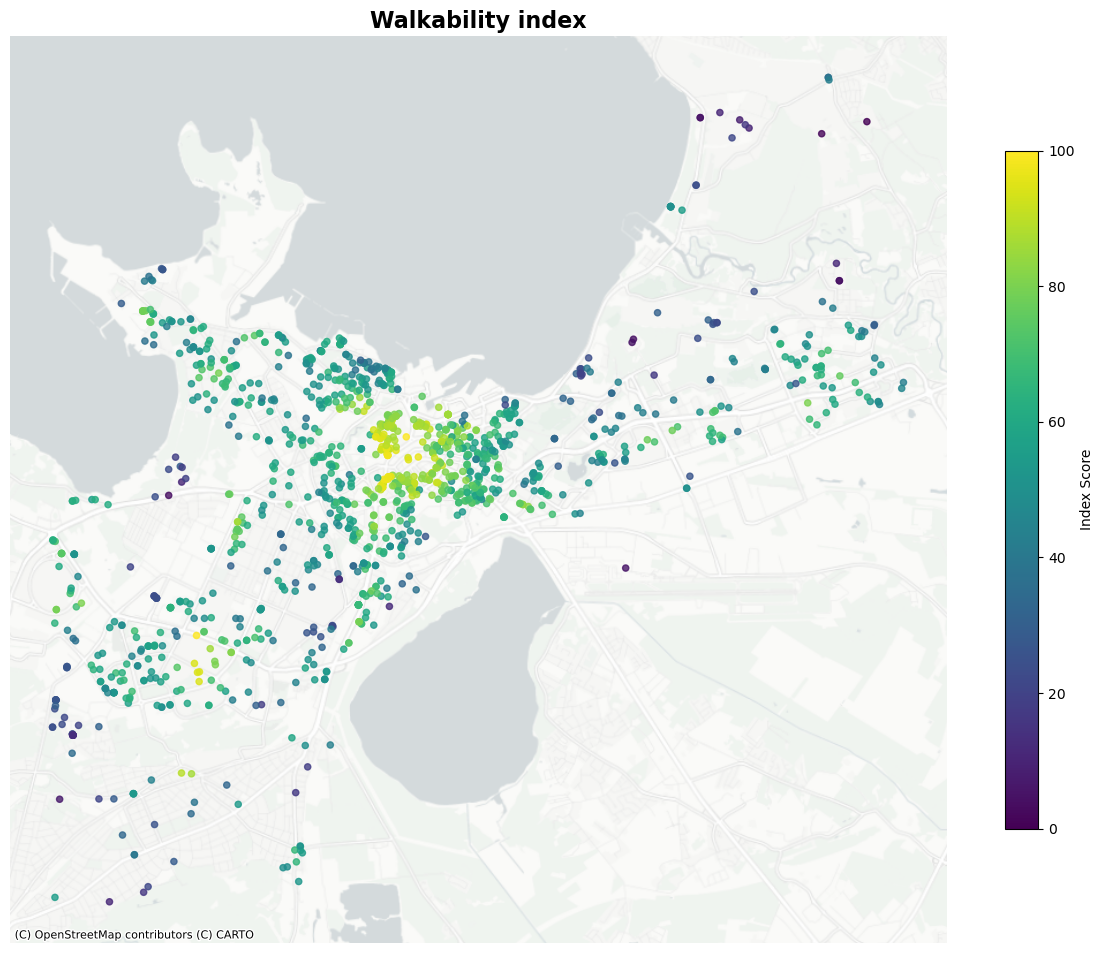

In [134]:
# output directory
output_dir = r"C:\Users\Dan\Documents\GitHub\KV-scraper-SAT\Final_maps"
# title and size
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
title = "Walkability index"

gdf_rent.plot(
    column="walkability_index",
    cmap="viridis",
    legend=True,
    markersize=20,
    alpha=0.8,
    ax=ax,
    vmin=0,   
    vmax=100, 
    legend_kwds={
        'label': "Index Score",
        'shrink': 0.7})

# Basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.PositronNoLabels, crs=gdf_rent.crs)
ax.set_title(title, fontsize=16, fontweight='bold')
ax.axis('off')

plt.tight_layout()
#save and plot
save_path = os.path.join(output_dir, f"{title}.png")
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

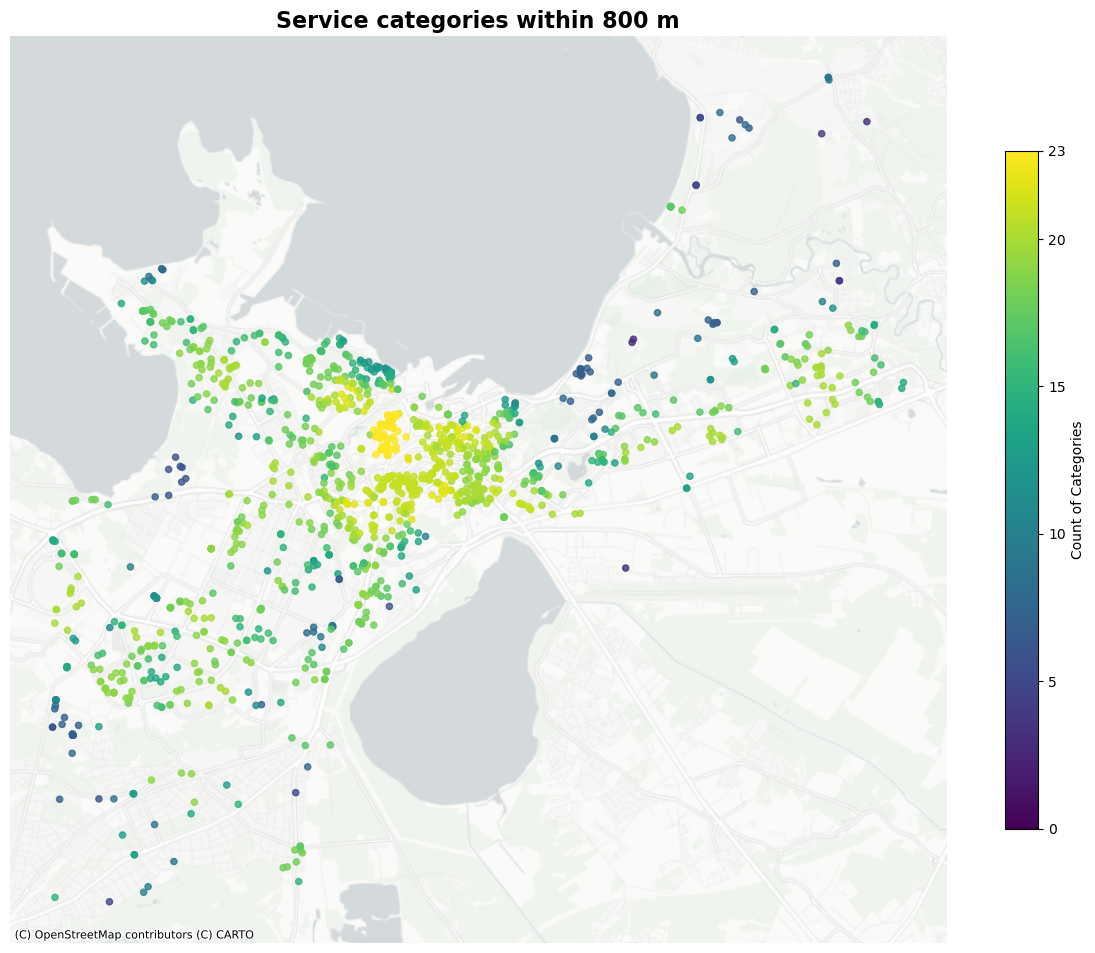

In [135]:
# output location
output_dir = r"C:\Users\Dan\Documents\GitHub\KV-scraper-SAT\Final_maps"

# caclulate maximum range of that for the scalebar
max_val = gdf_rent['amenity_diversity_net'].max()
# title and size
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
title = "Service categories within 800 m"


custom_ticks = [0, 5, 10, 15, 20, int(max_val)] # ticks we want on the scalebar
gdf_rent.plot(
    column="amenity_diversity_net",
    cmap="viridis",
    legend=True,
    markersize=20,
    alpha=0.8,
    ax=ax,
    vmin=0,           # start at 0
    vmax=max_val,     # end at exact max
    legend_kwds={
        'label': "Count of Categories",
        'orientation': "vertical",
        'ticks': custom_ticks, 
        'shrink': 0.7})

# Basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.PositronNoLabels, crs=gdf_rent.crs)

ax.set_title(title, fontsize=16, fontweight='bold')
ax.axis('off')

plt.tight_layout()

# 4. SAVE
save_path = os.path.join(output_dir, f"{title}.png")
plt.savefig(save_path, dpi=300, bbox_inches='tight')

### Saving the engineered features

In [ ]:
#gdf_rent.to_file("gdf_rent_engineered_tln.gpkg", layer="gdf_rent_engineered_tln", driver="GPKG")

In [ ]:
#gdf_rent_features = gpd.read_file("gdf_rent_engineered.gpkg", layer="gdf_rent_engineered")

In [ ]:
#gdf_rent_features.head()

# Model building (XGBoost with spacial CV (4000m folds when ≥ 10 listings), test set (Folds with < 10 listings), target encoding (2000m grid with average price of out of fold listings), categorised price (3 qunatiles)

### Imports

In [85]:
gdf_rent = gpd.read_file("gdf_rent_engineered_tln.gpkg", layer="gdf_rent_engineered_tln") # Import engineered rent data of Tallinn
asum_path = r"C:\Users\Dan\Documents\GitHub\KV-scraper-SAT\Analysis\Districts_data\asustusyksus.shp" # Importing .shp district file from Estonian Land and Spatial Development Board (Maa- ja ruumiamet) 
gdf_asum = gpd.read_file(asum_path)

### Finding which in district each point is

In [86]:
gdf_asum = gdf_asum.to_crs(gdf_rent.crs) # defining coordinate referece system
gdf_rent = gpd.sjoin(
    gdf_rent,
    gdf_asum[["ANIMI", "geometry"]],
    how="left",
    predicate="within") # spatial join

### Feature engineering again

In [87]:
# condition score value defining 5 - 0.5 score
condition_mapping = {
    'Uus': 5, 'San. remont tehtud': 4, 'Renoveeritud': 4,
    'Valmis': 3.5, 'Heas korras': 3, 'Keskmine': 2,
    'Vajab san. remonti': 1, 'Vajab renoveerimist': 0.5}

gdf_rent['condition_score'] = gdf_rent['condition'].map(condition_mapping).fillna(3) # mapping the values to the data

# derived features to improve the model
gdf_rent['age_of_building'] = 2025 - gdf_rent['build_year']
gdf_rent['floor_ratio'] = gdf_rent['floor'] / gdf_rent['total_floors'].replace(0, 1)
gdf_rent['room_density'] = gdf_rent['rooms'] / gdf_rent['area_sqm']
gdf_rent['condition_age_interaction'] = gdf_rent['condition_score'] * gdf_rent['age_of_building']
gdf_rent['floor_total_interaction'] = gdf_rent['floor_ratio'] * gdf_rent['total_floors']

### Categorise price per m2 into 3 classes to improve performace (3 price bins, quantile )

In [88]:
gdf_rent['price_category'] = pd.qcut(gdf_rent['price_per_m2'], q=3, labels=['budget', 'mid_range', 'premium']) # add lables to the categories

print("category distribution") # checking the distribution just in case
print(gdf_rent['price_category'].value_counts().sort_index())
print("ranges per category:") # checking the ranges generated
for cat in ['budget', 'mid_range', 'premium']:
    prices = gdf_rent[gdf_rent['price_category'] == cat]['price_per_m2']
    if len(prices) > 0:
        print(f"{cat}: {prices.min():.2f} - {prices.max():.2f} €/m2")

# mapping string labels to integers
label_mapping = {
    'budget': 0,
    'mid_range': 1,
    'premium': 2}
inv_label_mapping = {v: k for k, v in label_mapping.items()}
gdf_rent['price_category_int'] = gdf_rent['price_category'].map(label_mapping)

category distribution
price_category
budget       449
mid_range    447
premium      449
Name: count, dtype: int64
ranges per category:
budget: 2.68 - 12.50 €/m2
mid_range: 12.50 - 16.67 €/m2
premium: 16.68 - 47.14 €/m2


### Setting up grids for CV and target encoding

In [89]:
minx, miny, maxx, maxy = gdf_rent.total_bounds # finding bounding box for Tallinn's rental listings

# pulling out the longitude (x) and latitude (y) from each listing's location as separate numbers. Even though had latitude and longitude fields was not sure using those would work.
gdf_rent['geom_x'] = gdf_rent['geometry'].apply(lambda g: g.x)
gdf_rent['geom_y'] = gdf_rent['geometry'].apply(lambda g: g.y)

# defining feature grid for target encoding 
feature_grid_size = 2000 # setting the size of the grid
gdf_rent['grid_x'] = ((gdf_rent['geom_x'] - minx) // feature_grid_size).astype(int) # calculating grid coordinate x
gdf_rent['grid_y'] = ((gdf_rent['geom_y'] - miny) // feature_grid_size).astype(int) # calculating grid coordinate y
gdf_rent['grid_id'] = gdf_rent['grid_x'].astype(str) + "_" + gdf_rent['grid_y'].astype(str) # Assigning ID-s of which grid a point is within

# defining spatial CV blocks for crossvalidation
cv_block_size = 4000 # setting the size of the grid
gdf_rent['cv_block_x'] = ((gdf_rent['geom_x'] - minx) // cv_block_size).astype(int) # calculating grid coordinate x
gdf_rent['cv_block_y'] = ((gdf_rent['geom_y'] - miny) // cv_block_size).astype(int) # calculating grid coordinate y
gdf_rent['cv_block_id'] = gdf_rent['cv_block_x'].astype(str) + "_" + gdf_rent['cv_block_y'].astype(str) # Assigning ID-s of which grid a point is within

### Splitting data into CV dataset and Test dataset (test dataset will be all CV folds with less than 10 listings in them)

In [90]:
grid_counts = gdf_rent['grid_id'].value_counts() # counts how many rental listings are within each grid
valid_grids = grid_counts[grid_counts >= 10].index # counts valid grids with more than 10 listings
invalid_grids = grid_counts[grid_counts < 10].index # counts invalid grids with less than 10 listings

# output to toubleshoot/look at the data
print(f"Dataset split")
print(f"Feature grid size: {feature_grid_size}m") 
print(f"CV block size: {cv_block_size}m")
print(f"Total feature grid cells: {len(grid_counts)}")
print(f"Cells with ≥10 listings (CV dataset): {len(valid_grids)}")
print(f"Cells with <10 listings (Test dataset): {len(invalid_grids)}")

# spliting data based on if it is valid fold or no.
gdf_cv = gdf_rent[gdf_rent['grid_id'].isin(valid_grids)].copy()
gdf_test = gdf_rent[gdf_rent['grid_id'].isin(invalid_grids)].copy()

print(f"\nCV dataset size: {len(gdf_cv)}")
print(f"Test dataset size: {len(gdf_test)}")

# output to toubleshoot/look at the data
cv_block_counts = gdf_cv['cv_block_id'].value_counts()
print(f"\nCV blocks: {len(cv_block_counts)}")
print(f"Min listings per CV block: {cv_block_counts.min()}")
print(f"Max listings per CV block: {cv_block_counts.max()}")
print(f"Mean listings per CV block: {cv_block_counts.mean():.1f}")

Dataset split
Feature grid size: 2000m
CV block size: 4000m
Total feature grid cells: 30
Cells with ≥10 listings (CV dataset): 20
Cells with <10 listings (Test dataset): 10

CV dataset size: 1289
Test dataset size: 56

CV blocks: 9
Min listings per CV block: 12
Max listings per CV block: 518
Mean listings per CV block: 143.2


### Data preparation

In [91]:
# excluding these columns because they are either useless or would leak data or will be encoded later.
exclude_cols = [
    'id', 'url', 'geometry', 'price', 'price_per_m2', 'condition', 'nearest_node',
    'ANIMI', 'price_category', 'geom_x', 'geom_y', 
    'grid_x', 'grid_y', 'grid_id', 'cv_block_x', 'cv_block_y', 'cv_block_id']

# excluding score columns because they were created to create the walkability index and would basically mean the same thing as distance for the model (colinearity)
score_cols = [c for c in gdf_rent.columns if c.startswith("score_")]
exclude_cols.extend(score_cols) 
# creating a list of feature columns that are numeric and are not in excluded columns
feature_cols = [c for c in gdf_cv.columns
                if c not in exclude_cols
                and pd.api.types.is_numeric_dtype(gdf_cv[c])]

# creating CV dataset
X_cv = gdf_cv[feature_cols + ['ANIMI', 'grid_id']].copy() # Adding features. some features added back because they will be encoded later and will not be used as numeric features
y_cv_int = gdf_cv['price_category_int'].copy() # integer for classification
y_cv_str = gdf_cv['price_category'].copy() # string for reporing
y_cv_numeric = gdf_cv['price_per_m2'].copy() # numeric to check true errors
groups_cv = gdf_cv['cv_block_id'].copy() # each listing to its column

# Creating Test dataset
X_test = gdf_test[feature_cols + ['ANIMI', 'grid_id']].copy() # Adding features. some features added back because they will be encoded later and will not be used as numeric features
y_test_int = gdf_test['price_category_int'].copy() # integer for classification
y_test_str = gdf_test['price_category'].copy() # string for reporing
y_test_numeric = gdf_test['price_per_m2'].copy() # each listing to its column

### Defining functions for encoding

In [92]:
# Function for smooth target encoding for a grid or a district
def smooth_target_encoding(df, col, target, alpha=10): 
    global_mean = df[target].mean() # overall average of the target across the entire dataset
    stats = df.groupby(col)[target].agg(['mean', 'count']) # calculates the mean target value and number of samples in that category
    stats['smooth'] = (stats['mean'] * stats['count'] + global_mean * alpha) / (stats['count'] + alpha) # smoothing formula for overfitting
    return df[col].map(stats['smooth']).fillna(global_mean), stats # returns encoded column full stats table.

def apply_encoding_with_stats(df, col, stats, global_mean): # function for validation or test encoding to avoid data leakage
    return df[col].map(stats['smooth']).fillna(global_mean) # for each row of the new dataframe uses smoothed value. if no smooth value possible uses global_mean

### Spacial 5 fold CV loop creation

In [93]:
# creating 5 fold CV with groups. helps with dataleakage, listings from the same spatial block never appear in both train and val sets.
gkf = GroupKFold(n_splits=5)

# dictionary for storing CV evaluation metrics. # used for final reports
cv_results = {
    'fold': [],
    'accuracy': [],
    'kappa': [],
    'rmse': [],
    'mae': [],
    'mape': [],
    'r2': [],
    'train_size': [],
    'val_size': []}

# lists for collecting peredictons
all_y_true_str_cv = []
all_y_pred_str_cv = []
all_y_true_numeric_cv = []
all_y_pred_numeric_cv = []

# encoding stats from each fold for later averages. for each fold encoding tables, mean price_per_m2, etc are stored for averaging these to use on test dataset.
all_animi_stats = []
all_onimi_stats = []
all_grid_stats = []
all_global_means = []
all_category_medians = []

In [94]:
fold_assignment_map = {}  # map indices to fold numbers. for visualization
all_cv_probs = [] # collecting for visualizations
all_cv_indices = [] # collecting for visualizations

In [95]:
# for loop for each fold
for fold_idx, (train_idx, val_idx) in enumerate(gkf.split(X_cv, y_cv_int, groups=groups_cv), 1): # for each fold runs gkf.split to see what indexes to use for train and what for validation
    # for each fold decides which rows belong in which fold. Rows with the same group ID will always go together. 
    # fold assignment is based on spatial blocks, not random rows. prevents spacial leakage
    # Starts numbering at 1 for better printing
    print(f"\nFold {fold_idx}/5") # prints what fold is currently being processed
    # storing which fold these validation indices belong to for visualization
    for idx in val_idx:
        fold_assignment_map[idx] = fold_idx
    
    # splitting input features into training and validation subsets.
    X_train_fold = X_cv.iloc[train_idx].copy()
    X_val_fold = X_cv.iloc[val_idx].copy()

    # spliting target labels. both integer and string labels
    y_train_int = y_cv_int.iloc[train_idx].copy()
    y_val_int = y_cv_int.iloc[val_idx].copy()
    y_train_str = y_cv_str.iloc[train_idx].copy()
    y_val_str = y_cv_str.iloc[val_idx].copy()

    #spliting numeric target (price_per_m2)
    y_train_numeric_fold = y_cv_numeric.iloc[train_idx].copy()
    y_val_numeric_fold = y_cv_numeric.iloc[val_idx].copy()
    # printing fold sizes to know the balaces of the folds
    print(f"train size: {len(train_idx)} | val size: {len(val_idx)}")
    
    # target encoding within fold
    # computing global mean price. fallback
    global_mean = y_train_numeric_fold.mean()
    all_global_means.append(global_mean)

    # temporary df for target encoding 
    tmp_train_enc = X_train_fold[['ANIMI', 'grid_id']].copy()
    tmp_train_enc = tmp_train_enc.assign(price_per_m2=y_train_numeric_fold.values)
    
    # ANIMI encoding. target encoding for each district in tallinn
    # for training set smoothed encoding with defined function and gives encoded values + stats table
    # for validation set uses training encoding stats
    X_train_fold['ANIMI_enc'], animi_stats = smooth_target_encoding(
        tmp_train_enc, 'ANIMI', 'price_per_m2', alpha=10
    )
    X_val_fold['ANIMI_enc'] = apply_encoding_with_stats(
        X_val_fold, 'ANIMI', animi_stats, global_mean
    )
    all_animi_stats.append(animi_stats)
    
    # ONIMI encoding
    #X_train_fold['ONIMI_enc'], onimi_stats = smooth_target_encoding(
    #    tmp_train_enc, 'ONIMI', 'price_per_m2', alpha=10
    #)
    #X_val_fold['ONIMI_enc'] = apply_encoding_with_stats(
    #    X_val_fold, 'ONIMI', onimi_stats, global_mean
    #)
    #all_onimi_stats.append(onimi_stats)
    
    # Grid mean encoding
    # for training set smoothed encoding with defined function and gives encoded values + stats table
    # for validation set uses training encoding stats
    # alpha value is higher because grids can have less values within them than districts
    X_train_fold['grid_mean_price'], grid_stats = smooth_target_encoding(
        tmp_train_enc, 'grid_id', 'price_per_m2', alpha=20
    )
    X_val_fold['grid_mean_price'] = apply_encoding_with_stats(
        X_val_fold, 'grid_id', grid_stats, global_mean
    )
    all_grid_stats.append(grid_stats)
    
    # store category medians for this fold. used to convert class predictions to numeric predictions 
    label_list = ['budget', 'mid_range', 'premium']
    category_medians = y_train_numeric_fold.groupby(y_train_str).median()
    category_medians = category_medians.reindex(label_list).fillna(global_mean)
    all_category_medians.append(category_medians)
    
    # drop categorical columns to clean up feature set so only encoded versions remain
    X_train_fold = X_train_fold.drop(columns=['ANIMI', 'grid_id'])
    X_val_fold = X_val_fold.drop(columns=['ANIMI', 'grid_id'])
    
    # fill with training medians NaN values just incase.   
    train_medians = X_train_fold.median(numeric_only=True)
    X_train_fold = X_train_fold.fillna(train_medians)
    X_val_fold = X_val_fold.fillna(train_medians)
    X_val_fold = X_val_fold[X_train_fold.columns] # Aligning columns
    
    # MODEL XGBoost regularized
    model = XGBClassifier(
        n_estimators=150,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.6,
        min_child_weight=8,
        gamma=1.0,
        reg_alpha=2.0,
        reg_lambda=3.0,
        random_state=42,
        n_jobs=-1,
        eval_metric='mlogloss'
    )
    
    model.fit(X_train_fold, y_train_int, verbose=False) # train model on train data
    
    # predictions
    y_pred_int = model.predict(X_val_fold) # integer label
    # prediction probabilities for visualizations #####
    probs_fold = model.predict_proba(X_val_fold)  
    all_cv_probs.append(probs_fold)
    all_cv_indices.append(val_idx)
    y_pred_str = pd.Series(y_pred_int).map(inv_label_mapping).astype(object) # integer label to string label
    
    # metrics 
    acc = accuracy_score(y_val_str, y_pred_str)
    kappa = cohen_kappa_score(y_val_str, y_pred_str)
    
    y_pred_numeric_fold = pd.Series(y_pred_str).map(category_medians).values # predicted categories to numeric prices

    # regression metrics 
    rmse = np.sqrt(mean_squared_error(y_val_numeric_fold, y_pred_numeric_fold))
    mae = mean_absolute_error(y_val_numeric_fold, y_pred_numeric_fold)
    mape = mean_absolute_percentage_error(y_val_numeric_fold, y_pred_numeric_fold)
    r2 = r2_score(y_val_numeric_fold, y_pred_numeric_fold)

    # metrics and predictions stroed
    cv_results['fold'].append(fold_idx)
    cv_results['accuracy'].append(acc)
    cv_results['kappa'].append(kappa)
    cv_results['rmse'].append(rmse)
    cv_results['mae'].append(mae)
    cv_results['mape'].append(mape)
    cv_results['r2'].append(r2)
    cv_results['train_size'].append(len(train_idx))
    cv_results['val_size'].append(len(val_idx))
    
    all_y_true_str_cv.extend(y_val_str.tolist())
    all_y_pred_str_cv.extend(y_pred_str.tolist())
    all_y_true_numeric_cv.extend(y_val_numeric_fold.tolist())
    all_y_pred_numeric_cv.extend(y_pred_numeric_fold.tolist())

    # printing results for each fold
    print(f"accuracy: {acc:.4f} | kappa: {kappa:.4f}")
    print(f"RMSE: {rmse:.2f} | MAE: {mae:.2f} | MAPE: {mape*100:.2f}% | R2: {r2:.4f}")


Fold 1/5
train size: 771 | val size: 518


C:\Users\Dan\AppData\Local\Temp\ipykernel_12308\3853644463.py:70: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_medians = y_train_numeric_fold.groupby(y_train_str).median()


accuracy: 0.5946 | kappa: 0.3923
RMSE: 4.01 | MAE: 3.03 | MAPE: 20.78% | R2: 0.2170

Fold 2/5
train size: 1074 | val size: 215


C:\Users\Dan\AppData\Local\Temp\ipykernel_12308\3853644463.py:70: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_medians = y_train_numeric_fold.groupby(y_train_str).median()


accuracy: 0.5070 | kappa: 0.2788
RMSE: 5.34 | MAE: 3.95 | MAPE: 21.97% | R2: 0.0232

Fold 3/5
train size: 1111 | val size: 178


C:\Users\Dan\AppData\Local\Temp\ipykernel_12308\3853644463.py:70: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_medians = y_train_numeric_fold.groupby(y_train_str).median()


accuracy: 0.6966 | kappa: 0.5462
RMSE: 3.79 | MAE: 2.54 | MAPE: 16.60% | R2: 0.5055

Fold 4/5
train size: 1082 | val size: 207


C:\Users\Dan\AppData\Local\Temp\ipykernel_12308\3853644463.py:70: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_medians = y_train_numeric_fold.groupby(y_train_str).median()


accuracy: 0.6232 | kappa: 0.4281
RMSE: 3.42 | MAE: 2.63 | MAPE: 18.94% | R2: 0.4296

Fold 5/5
train size: 1118 | val size: 171


C:\Users\Dan\AppData\Local\Temp\ipykernel_12308\3853644463.py:70: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_medians = y_train_numeric_fold.groupby(y_train_str).median()


accuracy: 0.7310 | kappa: 0.5885
RMSE: 4.14 | MAE: 2.66 | MAPE: 17.77% | R2: 0.5001


In [96]:
# Save fold assignments for later visualization
gdf_cv['fold_assignment'] = gdf_cv.index.map(fold_assignment_map)

In [97]:
# realign for later visualizations
cv_probs_full = np.zeros((len(X_cv), 3)) 
for idxs, probs in zip(all_cv_indices, all_cv_probs):
    cv_probs_full[idxs] = probs

### CV results overview

In [98]:
results_df = pd.DataFrame(cv_results)
print("spatial CV sumary for CV data")
print(results_df.to_string(index=False))
print("mean metrics:")
print(f"Accuracy:  {results_df['accuracy'].mean():.4f} (±{results_df['accuracy'].std():.4f})")
print(f"Kappa:     {results_df['kappa'].mean():.4f} (±{results_df['kappa'].std():.4f})")
print(f"RMSE:      {results_df['rmse'].mean():.2f} (±{results_df['rmse'].std():.2f})")
print(f"MAE:       {results_df['mae'].mean():.2f} (±{results_df['mae'].std():.2f})")
print(f"MAPE:      {results_df['mape'].mean()*100:.2f}% (±{results_df['mape'].std()*100:.2f}%)")
print(f"R²:        {results_df['r2'].mean():.4f} (±{results_df['r2'].std():.4f})")

spatial CV sumary for CV data
 fold  accuracy    kappa     rmse      mae     mape       r2  train_size  val_size
    1  0.594595 0.392270 4.006434 3.031305 0.207838 0.216995         771       518
    2  0.506977 0.278843 5.336821 3.947560 0.219654 0.023174        1074       215
    3  0.696629 0.546176 3.787085 2.542216 0.166020 0.505544        1111       178
    4  0.623188 0.428076 3.419386 2.625629 0.189397 0.429566        1082       207
    5  0.730994 0.588512 4.144331 2.657595 0.177727 0.500108        1118       171
mean metrics:
Accuracy:  0.6305 (±0.0881)
Kappa:     0.4468 (±0.1240)
RMSE:      4.14 (±0.72)
MAE:       2.96 (±0.58)
MAPE:      19.21% (±2.18%)
R²:        0.3351 (±0.2100)


### final model on entire dataset

In [99]:
# copy data to make sure original data stays
X_cv_full = X_cv.copy() 
y_cv_full_int = y_cv_int.copy()
y_cv_full_str = y_cv_str.copy()
y_cv_full_numeric = y_cv_numeric.copy()

# average of 5 fold means to encode full dataset
global_mean_final = np.mean(all_global_means)

# merging encoding stats across all folds
def combine_stats(all_stats_list, global_mean):
    combined = pd.concat([s['smooth'] for s in all_stats_list], axis=1).mean(axis=1)
    return combined
# final encoding to full dataset
animi_enc_final = X_cv_full['ANIMI'].map(combine_stats(all_animi_stats, global_mean_final)).fillna(global_mean_final)
#onimi_enc_final = X_cv_full['ONIMI'].map(combine_stats(all_onimi_stats, global_mean_final)).fillna(global_mean_final)
grid_enc_final = X_cv_full['grid_id'].map(combine_stats(all_grid_stats, global_mean_final)).fillna(global_mean_final)
# encoded features and drop categorical columns
X_cv_full['ANIMI_enc'] = animi_enc_final
#X_cv_full['ONIMI_enc'] = onimi_enc_final
X_cv_full['grid_mean_price'] = grid_enc_final
X_cv_full = X_cv_full.drop(columns=['ANIMI', 'grid_id'])

# missing numeric values filled with median just incase
cv_medians = X_cv_full.median(numeric_only=True)
X_cv_full = X_cv_full.fillna(cv_medians)

#final model. hyperparameters are the same
final_model = XGBClassifier(
    n_estimators=150,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.6,
    min_child_weight=8,
    gamma=1.0,
    reg_alpha=2.0,
    reg_lambda=3.0,
    random_state=42,
    n_jobs=-1,
    eval_metric='mlogloss'
)

final_model.fit(X_cv_full, y_cv_full_int, verbose=False)
print("done")

done


### Predicting onto test set (CV grids with <10 listings)

In [100]:
X_test_pred = X_test.copy() # copy of the test features

# Apply averaged encoding if doesnt exist uses global mean
X_test_pred['ANIMI_enc'] = X_test_pred['ANIMI'].map(
    combine_stats(all_animi_stats, global_mean_final)
).fillna(global_mean_final)

#X_test_pred['ONIMI_enc'] = X_test_pred['ONIMI'].map(
    #combine_stats(all_onimi_stats, global_mean_final)
#).fillna(global_mean_final)

# Apply averaged encoding if doesnt exist uses global mean
X_test_pred['grid_mean_price'] = X_test_pred['grid_id'].map(
    combine_stats(all_grid_stats, global_mean_final)
).fillna(global_mean_final)

X_test_pred = X_test_pred.drop(columns=['ANIMI', 'grid_id']) # Drop categorical columns
# missing values and align columns
X_test_pred = X_test_pred.fillna(cv_medians) # 
X_test_pred = X_test_pred[X_cv_full.columns]

# making predictions onto the test dataset
y_test_pred_int = final_model.predict(X_test_pred)
test_probs = final_model.predict_proba(X_test_pred)
y_test_pred_str = pd.Series(y_test_pred_int).map(inv_label_mapping).astype(object)

# Use averaged category medians for numeric predictions
# predicted class mapped to its average median price across folds. similar to predicting actual price per m2. used for MAPE etc. getting an overview of the model performace
avg_category_medians = pd.concat(all_category_medians, axis=1).mean(axis=1)
y_test_pred_numeric = pd.Series(y_test_pred_str).map(avg_category_medians).values

# metrics
test_acc = accuracy_score(y_test_str, y_test_pred_str) # class prediction metrics
test_kappa = cohen_kappa_score(y_test_str, y_test_pred_str) # class prediction metrics
test_rmse = np.sqrt(mean_squared_error(y_test_numeric, y_test_pred_numeric)) # numeric prediction metric
test_mae = mean_absolute_error(y_test_numeric, y_test_pred_numeric) # numeric prediction metric
test_mape = mean_absolute_percentage_error(y_test_numeric, y_test_pred_numeric) # numeric prediction metric
test_r2 = r2_score(y_test_numeric, y_test_pred_numeric) # numeric prediction metric

# printing metrics
print(f"\nTest Set Size: {len(y_test_str)}")
print(f"Accuracy:  {test_acc:.4f}") # class prediction metrics
print(f"Kappa:     {test_kappa:.4f}") # class prediction metrics
print(f"RMSE:      {test_rmse:.2f}") # numeric prediction metric
print(f"MAE:       {test_mae:.2f}") # numeric prediction metric
print(f"MAPE:      {test_mape*100:.2f}%") # numeric prediction metric
print(f"R²:        {test_r2:.4f}") # numeric prediction metric


label_list = ['budget', 'mid_range', 'premium']
print(classification_report(y_test_str, y_test_pred_str, labels=label_list, zero_division=0)) # precision, recall, f1-score for each class

print("\nTest set confusion matrix:")
cm_test = confusion_matrix(y_test_str, y_test_pred_str, labels=label_list)
cm_test_df = pd.DataFrame(cm_test, index=label_list, columns=label_list)
print(cm_test_df)


Test Set Size: 56
Accuracy:  0.7143
Kappa:     0.5518
RMSE:      4.01
MAE:       2.85
MAPE:      21.78%
R²:        0.2766
              precision    recall  f1-score   support

      budget       0.69      0.96      0.80        23
   mid_range       0.86      0.38      0.52        16
     premium       0.71      0.71      0.71        17

    accuracy                           0.71        56
   macro avg       0.75      0.68      0.68        56
weighted avg       0.74      0.71      0.69        56


Test set confusion matrix:
           budget  mid_range  premium
budget         22          1        0
mid_range       5          6        5
premium         5          0       12


In [101]:
# adding all prediction probabilities into the same dataframe for visualizations 
all_probs = np.vstack([cv_probs_full, test_probs])
all_coords = np.vstack([
    gdf_cv[['geom_x', 'geom_y']].values,
    gdf_test[['geom_x', 'geom_y']].values
])
all_categories = np.concatenate([y_cv_full_int, y_test_pred_int])

### Overall performace of crossvalidation

In [102]:
label_list = ['budget', 'mid_range', 'premium']
print(classification_report(all_y_true_str_cv, all_y_pred_str_cv, labels=label_list, zero_division=0))

print("\nCV Confusion Matrix:")
cm_cv = confusion_matrix(all_y_true_str_cv, all_y_pred_str_cv, labels=label_list)
cm_cv_df = pd.DataFrame(cm_cv, index=label_list, columns=label_list)
print(cm_cv_df)

              precision    recall  f1-score   support

      budget       0.61      0.74      0.67       426
   mid_range       0.51      0.48      0.50       431
     premium       0.75      0.63      0.69       432

    accuracy                           0.62      1289
   macro avg       0.62      0.62      0.62      1289
weighted avg       0.62      0.62      0.62      1289


CV Confusion Matrix:
           budget  mid_range  premium
budget        315         87       24
mid_range     156        207       68
premium        49        110      273


# Visualizations

### Fold visualisations

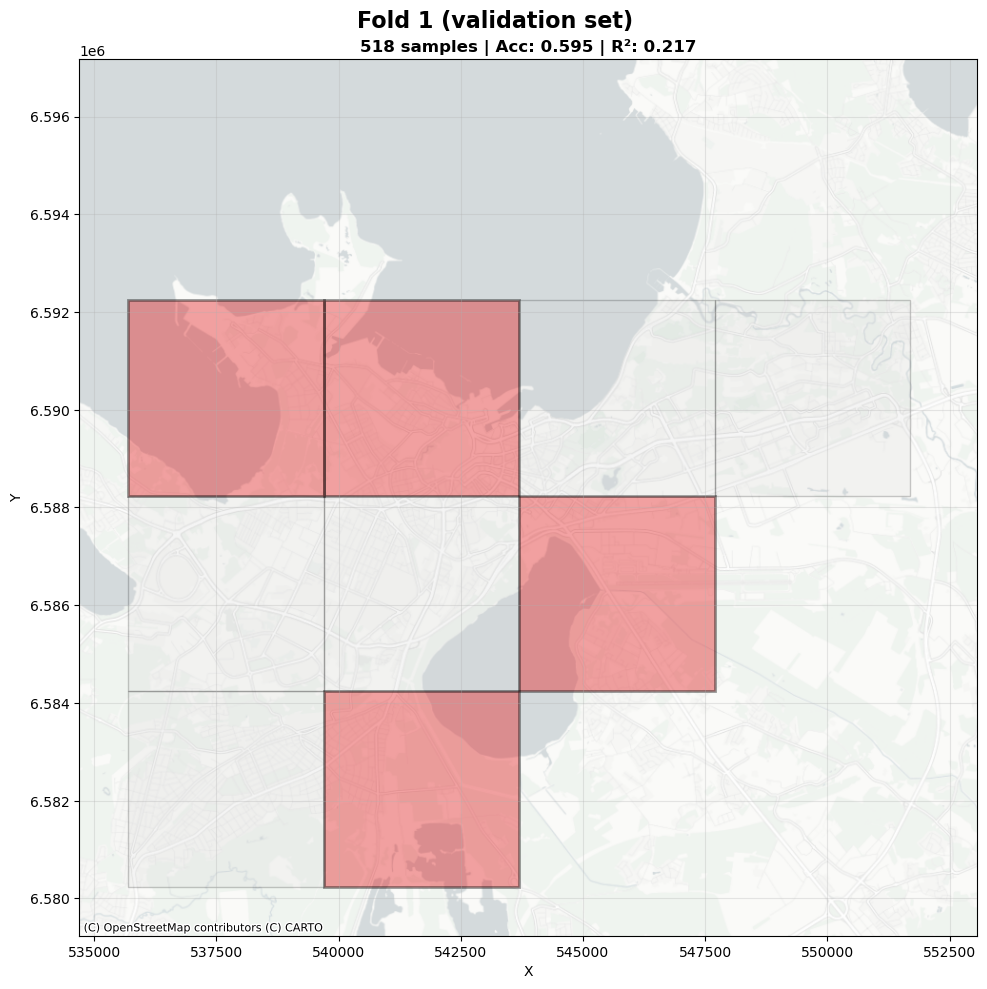

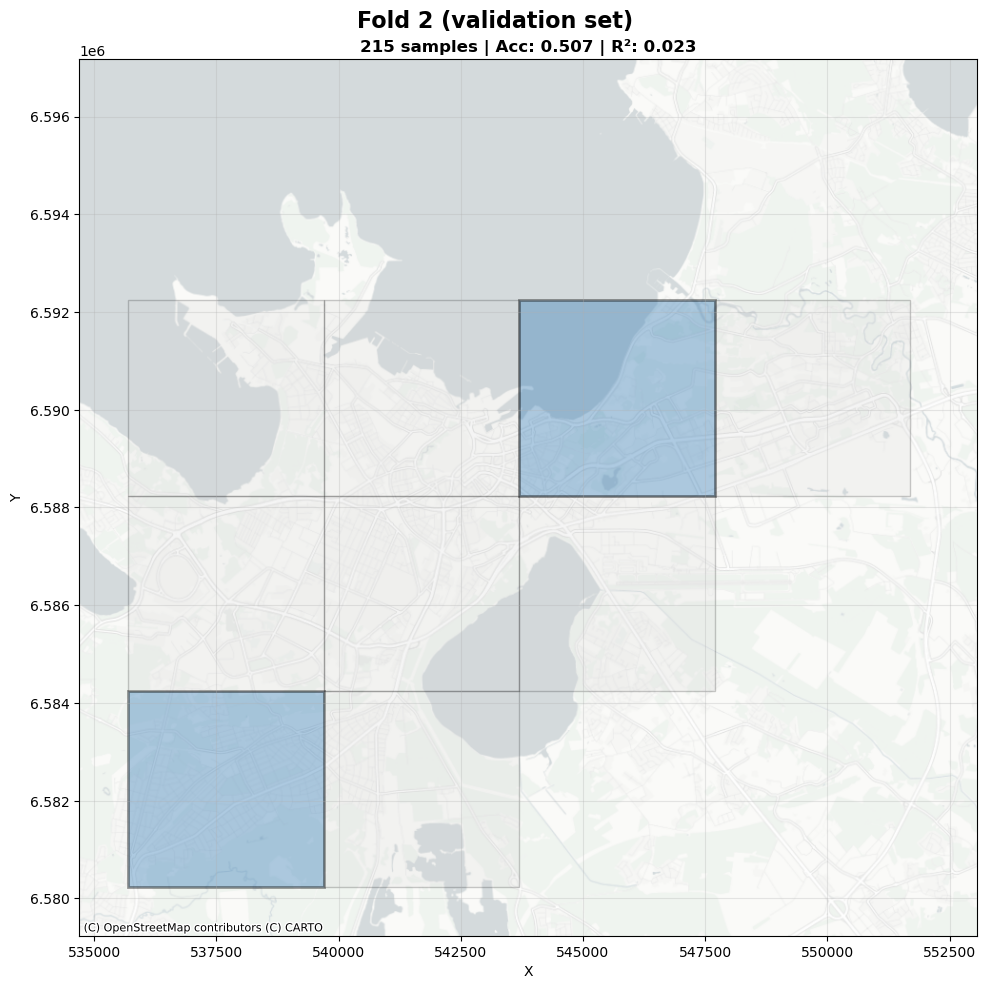

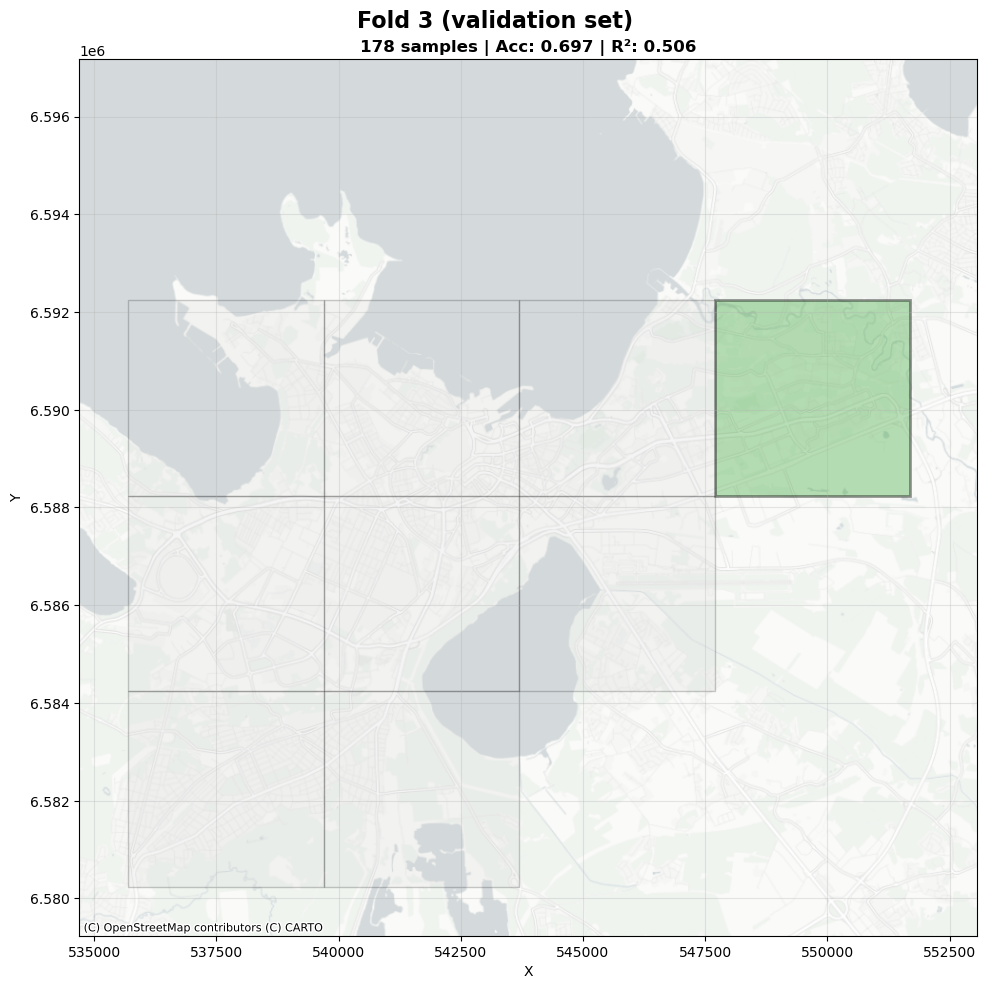

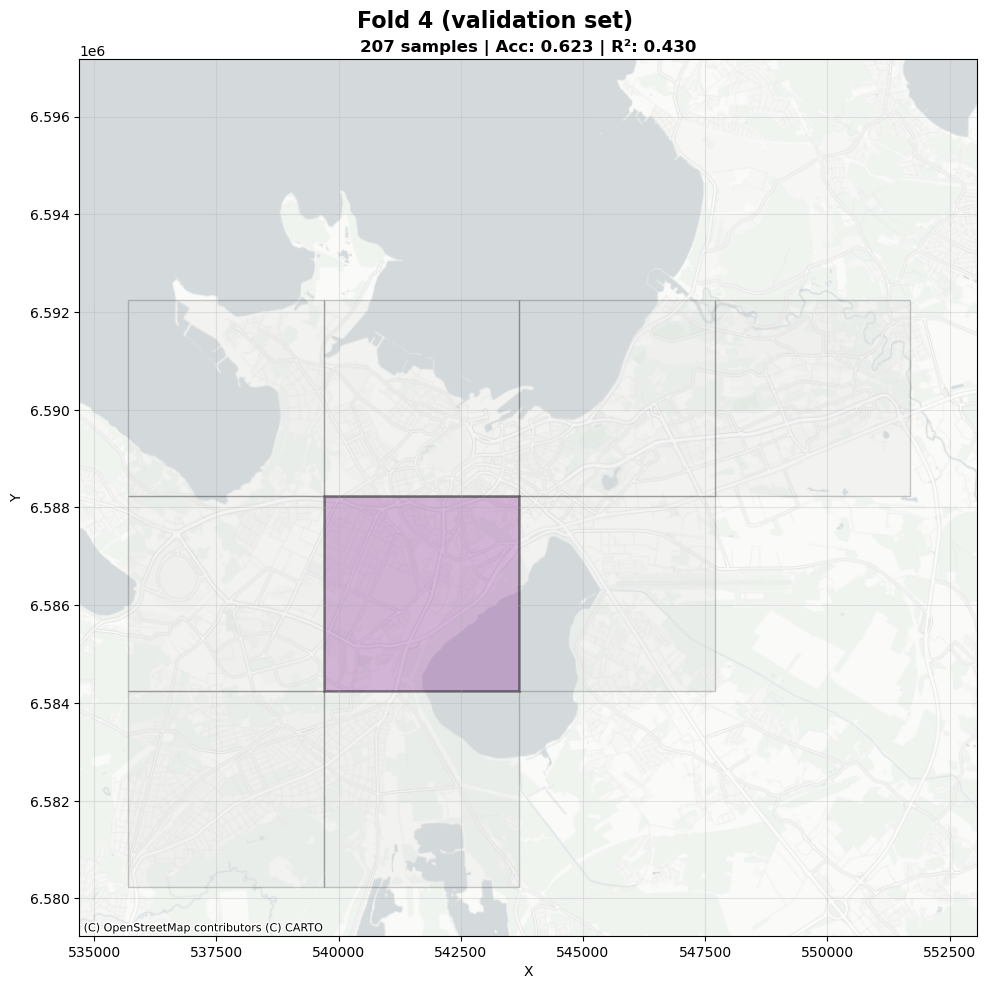

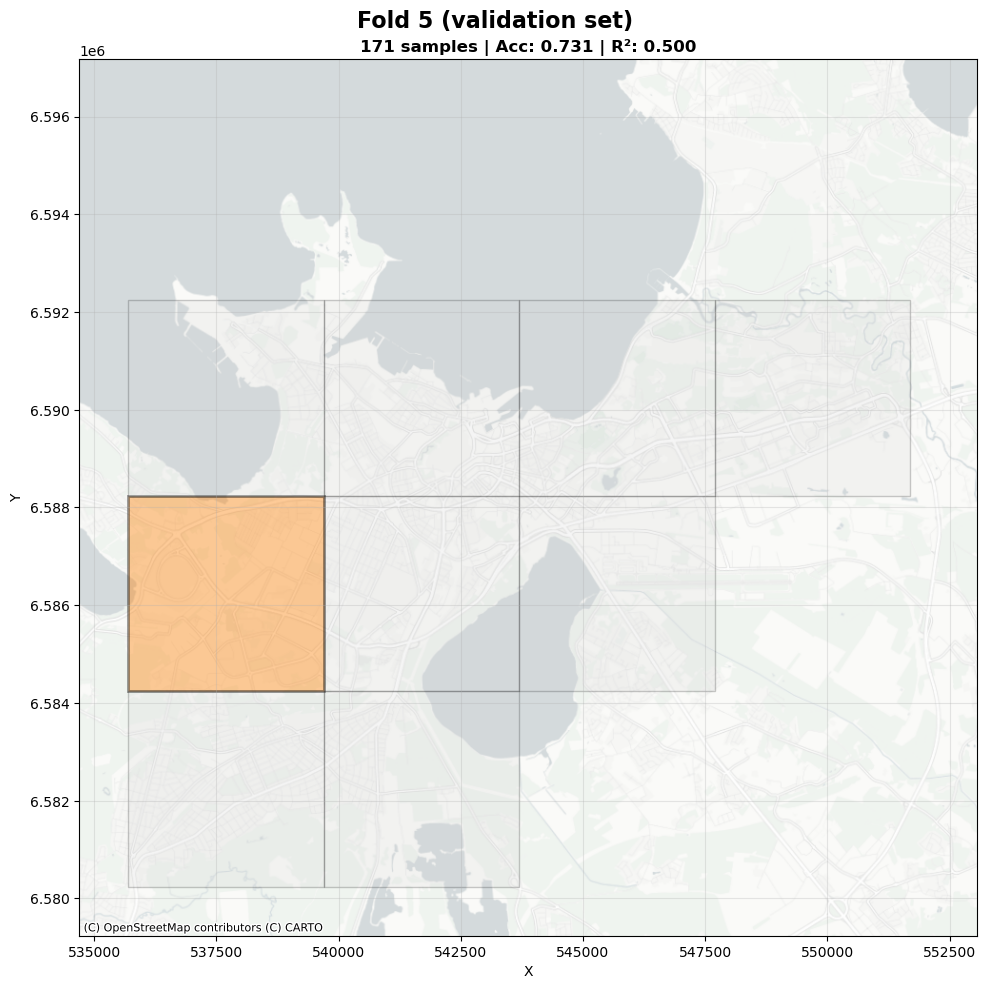

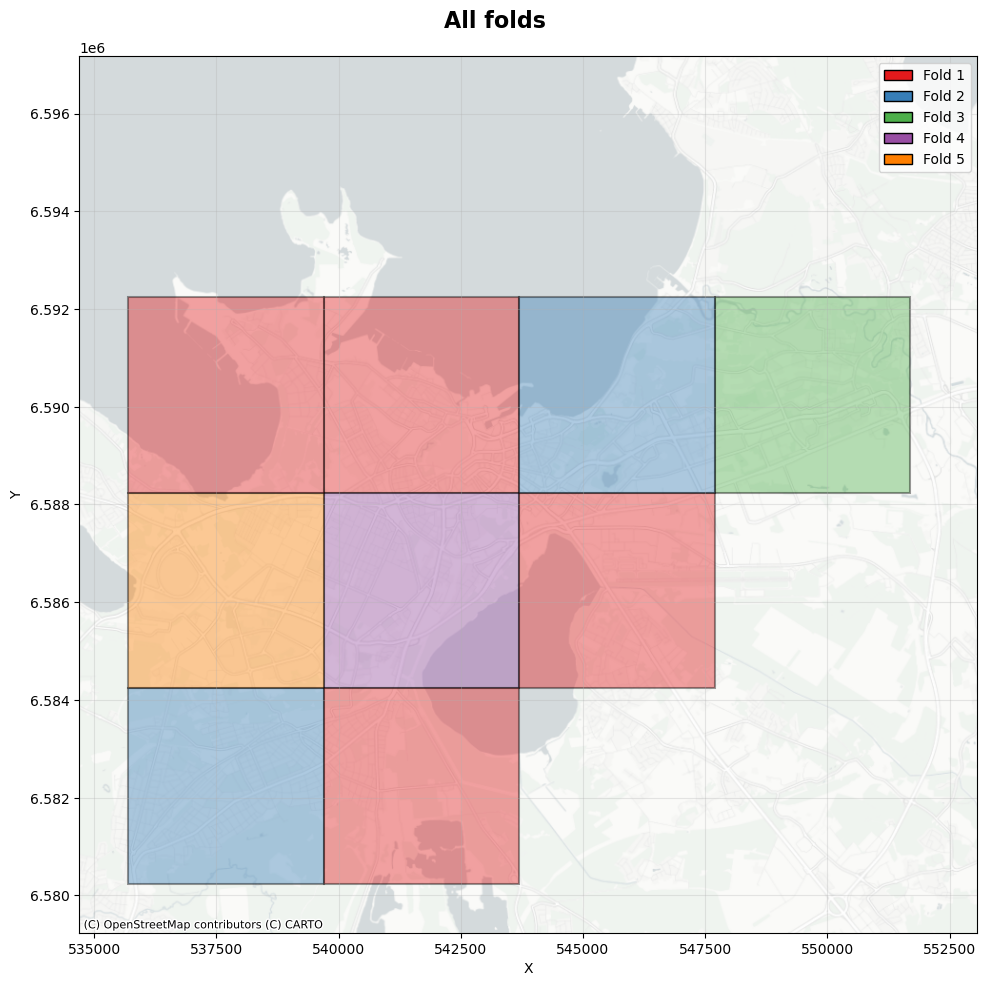

In [114]:
# Output directory
output_dir = r"C:\Users\Dan\Documents\GitHub\KV-scraper-SAT\Final_maps"
# mapping each cv_block_id to its fold using the saved assignments
block_to_fold = {}
for idx, row in gdf_cv.iterrows():
    block_id = row['cv_block_id']
    fold = row['fold_assignment']
    if pd.notna(fold):
        block_to_fold[block_id] = int(fold)

#unique blocks with their coordinates
unique_blocks = gdf_cv[['cv_block_id', 'cv_block_x', 'cv_block_y']].drop_duplicates()

# colors for each fold
fold_colors = {1: '#e41a1c', 2: '#377eb8', 3: '#4daf4a', 4: '#984ea3', 5: '#ff7f00'}

# plotting each fold 1-5
for fold in [1, 2, 3, 4, 5]:
    fig, ax = plt.subplots(figsize=(10, 10))
    plot_title = f'Fold {fold} (validation set)'
    fig.suptitle(plot_title, fontsize=16, fontweight='bold')
    
    # drawing all grid squares
    for _, row in unique_blocks.iterrows():
        block_id = row['cv_block_id']
        block_fold = block_to_fold.get(block_id, None)
        
        x_start = minx + row['cv_block_x'] * cv_block_size
        y_start = miny + row['cv_block_y'] * cv_block_size
        
        if block_fold == fold:
            color = fold_colors[fold]
            alpha = 0.4
            linewidth = 2
        else:
            color = 'lightgray'
            alpha = 0.2
            linewidth = 1
        
        rect = mpatches.Rectangle((x_start, y_start), cv_block_size, cv_block_size,
                                   linewidth=linewidth, edgecolor='black', facecolor=color, alpha=alpha)
        ax.add_patch(rect)
    
    #limits to use basemap
    ax.set_xlim(minx - 1000, maxx + 1000)
    ax.set_ylim(miny - 1000, maxy + 1000)
    
    # CartoDB basemap in ESPG_3301
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.PositronNoLabels, crs=gdf_rent.crs.to_string())
    
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    
    #performance metrics to title
    acc = cv_results['accuracy'][fold-1]
    r2 = cv_results['r2'][fold-1]
    val_size = cv_results['val_size'][fold-1]
    ax.set_title(f'{val_size} samples | Acc: {acc:.3f} | R²: {r2:.3f}', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    # saving
    safe_title = f"Fold_{fold}_validation_set"
    save_path = os.path.join(output_dir, f"{safe_title}.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# all folds combined
fig, ax = plt.subplots(figsize=(10, 10))
plot_title = 'All folds'
fig.suptitle(plot_title, fontsize=16, fontweight='bold')

for _, row in unique_blocks.iterrows():
    block_id = row['cv_block_id']
    block_fold = block_to_fold.get(block_id, None)
    
    x_start = minx + row['cv_block_x'] * cv_block_size
    y_start = miny + row['cv_block_y'] * cv_block_size
    
    if block_fold is not None:
        color = fold_colors[block_fold]
        alpha = 0.4
    else:
        color = 'lightgray'
        alpha = 0.2
    
    rect = mpatches.Rectangle((x_start, y_start), cv_block_size, cv_block_size,
                               linewidth=1.5, edgecolor='black', facecolor=color, alpha=alpha)
    ax.add_patch(rect)

#limits to use basemap
ax.set_xlim(minx - 1000, maxx + 1000)
ax.set_ylim(miny - 1000, maxy + 1000)

# adding basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.PositronNoLabels, crs=gdf_rent.crs.to_string())

ax.set_aspect('equal')
ax.grid(True, alpha=0.3)
ax.set_xlabel('X')
ax.set_ylabel('Y')

# legend
legend_elements = [mpatches.Patch(facecolor=fold_colors[f], edgecolor='black', label=f'Fold {f}') for f in range(1, 6)]
ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
save_path = os.path.join(output_dir, "All_folds_combined.png")
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

### Price per m2 category interpolation map predicted values vs real values

interpolating
masking
category ranges:
  Budget (2.68 - 12.50 €/m²)
  Mid-range (12.50 - 16.67 €/m²)
  Premium (16.68 - 47.14 €/m²)


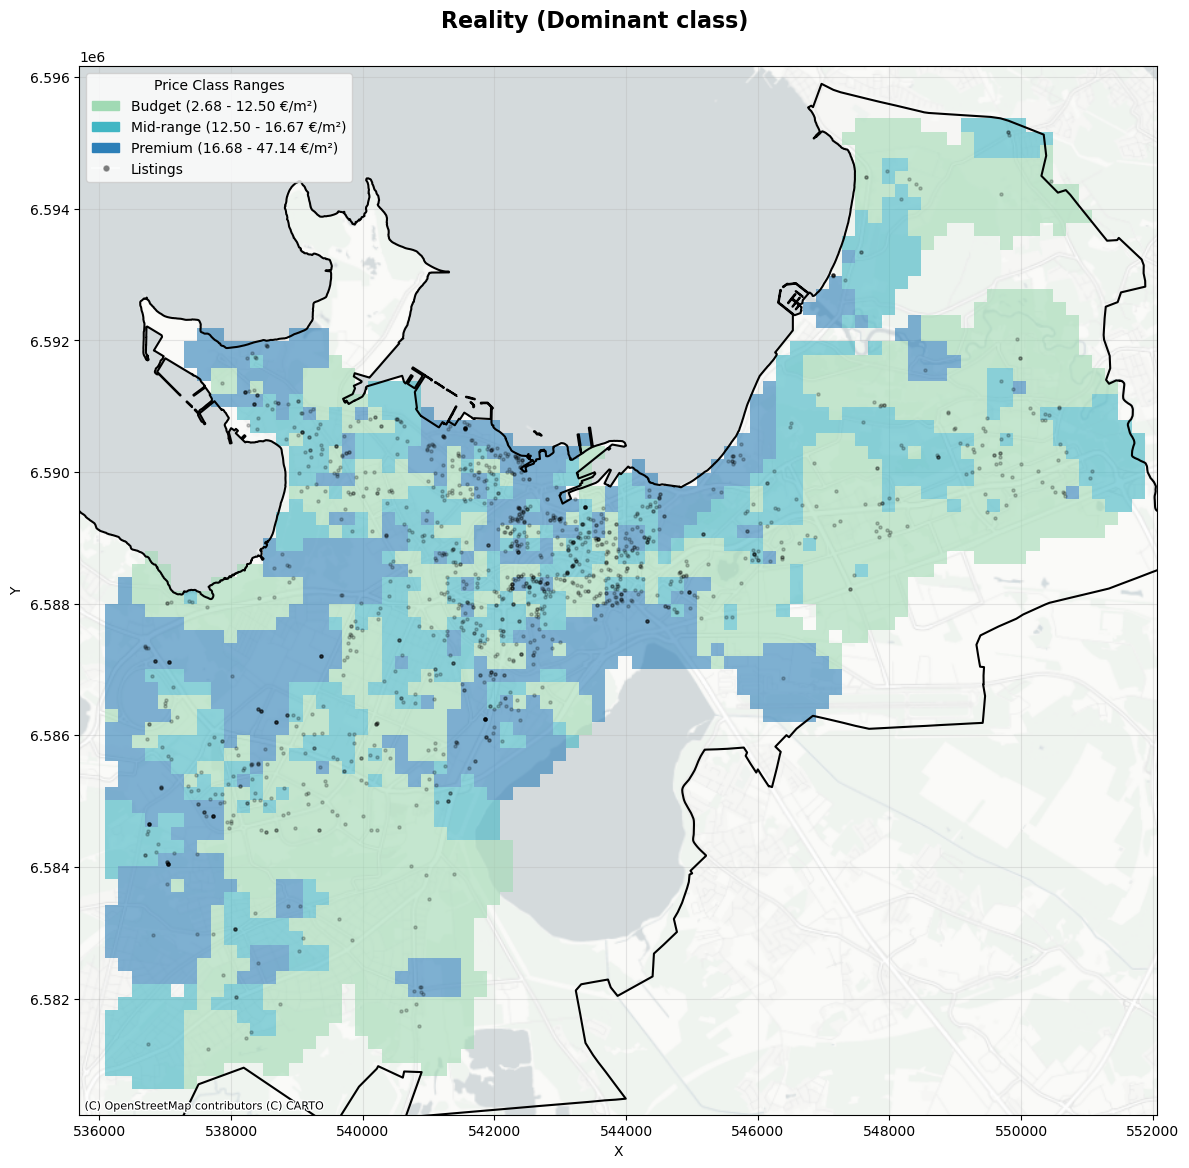

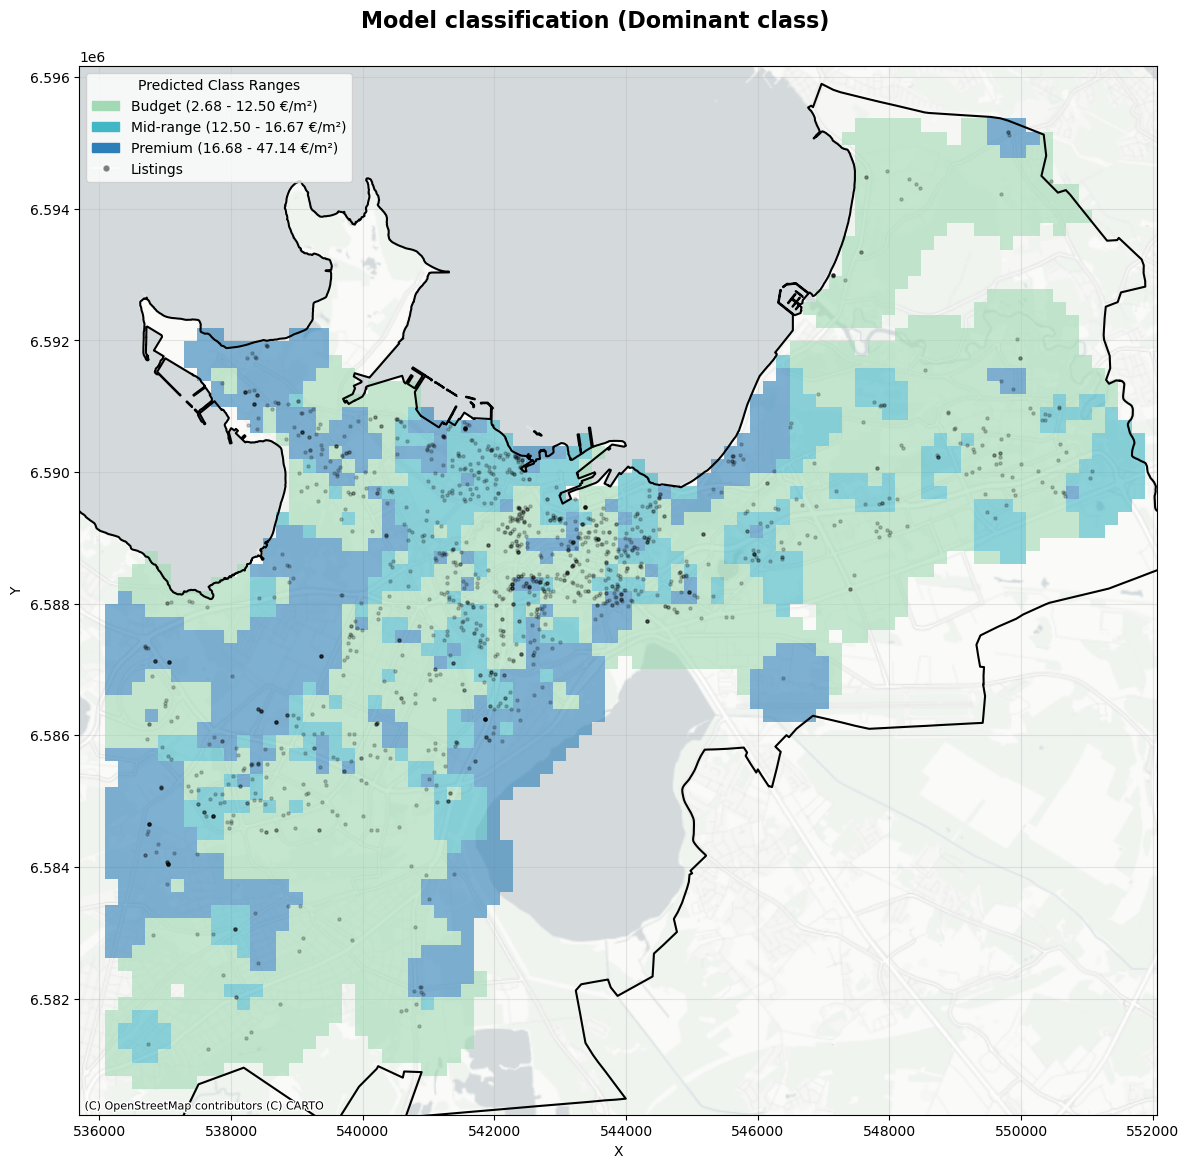

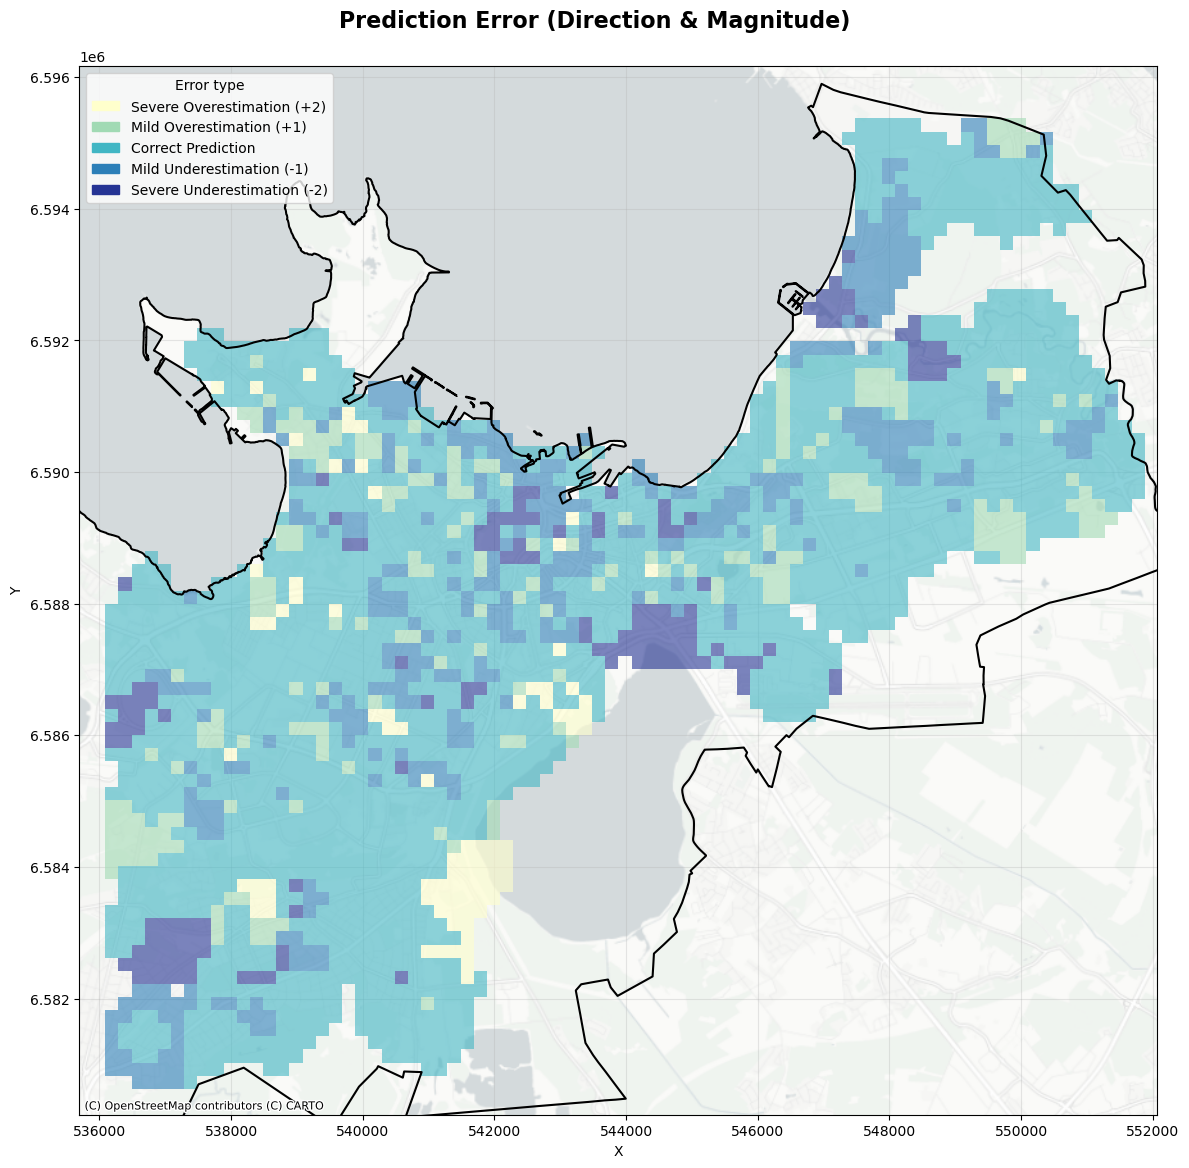

In [132]:
# defining where maps will be saved
output_dir = r"C:\Users\Dan\Documents\GitHub\KV-scraper-SAT\Final_maps"
# data preparation

# one hot encoding the data and adding CV results and test results into the same array
y_real = np.concatenate([y_cv_full_int, y_test_int])
real_probs_onehot = np.eye(3)[y_real] 
# storing class probabilities
pred_probs = all_probs

# Getting all coordinates
coords = np.vstack([
    gdf_cv[['geom_x', 'geom_y']].values,
    gdf_test[['geom_x', 'geom_y']].values])
# setup grid/bounding box off all points
minx, miny = coords.min(axis=0)
maxx, maxy = coords.max(axis=0)
# buffer so every point is easily visible
buffer = 1000 
minx -= buffer; maxx += buffer
miny -= buffer; maxy += buffer
# Making a 200m grid over tallinn for interpolation
resolution = 200 # meters
xi = np.arange(minx, maxx, resolution)
yi = np.arange(miny, maxy, resolution)
xi_grid, yi_grid = np.meshgrid(xi, yi)
# getting Tallinn data
gdf_asum = gpd.read_file(asum_path)
tallinn_geom = gdf_asum[gdf_asum['ONIMI'] == 'Tallinn'].union_all()


# interpolation function (Inverse Distance weighted)
def idw_fast(coords, values, xi_grid, yi_grid, k=15, power=2):
    grid_points = np.column_stack((xi_grid.ravel(), yi_grid.ravel()))
    tree = cKDTree(coords)
    dist, idx = tree.query(grid_points, k=k)
    dist = np.maximum(dist, 1e-10)
    weights = 1.0 / dist**power
    zi = np.sum(weights * values[idx], axis=1) / np.sum(weights, axis=1)
    return zi.reshape(xi_grid.shape)

print("interpolating")

# interpolate each class separately for both real and predicted
# helps to avoid 0 and 2 averaging to 1
grid_real_class0 = idw_fast(coords, real_probs_onehot[:,0], xi_grid, yi_grid)
grid_real_class1 = idw_fast(coords, real_probs_onehot[:,1], xi_grid, yi_grid)
grid_real_class2 = idw_fast(coords, real_probs_onehot[:,2], xi_grid, yi_grid)

grid_pred_class0 = idw_fast(coords, pred_probs[:,0], xi_grid, yi_grid)
grid_pred_class1 = idw_fast(coords, pred_probs[:,1], xi_grid, yi_grid)
grid_pred_class2 = idw_fast(coords, pred_probs[:,2], xi_grid, yi_grid)

# stacking
stack_real = np.stack([grid_real_class0, grid_real_class1, grid_real_class2], axis=-1)
stack_pred = np.stack([grid_pred_class0, grid_pred_class1, grid_pred_class2], axis=-1)

# winner takes al
# in each grid cell find which class has highest probability.
Z_real_cat = np.argmax(stack_real, axis=-1).astype(float)
Z_pred_cat = np.argmax(stack_pred, axis=-1).astype(float)

# MASKING

print("masking")
flat_grid = np.column_stack((xi_grid.ravel(), yi_grid.ravel()))
# looping over pieces to deal with multipolygons
parts = list(tallinn_geom.geoms) if hasattr(tallinn_geom, 'geoms') else [tallinn_geom]
mask_city_flat = np.zeros(len(flat_grid), dtype=bool)
for part in parts:
    path = mpltPath.Path(list(part.exterior.coords))
    mask_city_flat = mask_city_flat | path.contains_points(flat_grid)

# helps with interpolating into empty areas(forests/lakes) far from data
tree = cKDTree(coords)
dists_to_data, _ = tree.query(flat_grid, k=1)
mask_buffer_flat = dists_to_data <= 800 # 800 meter buffer around points
# combining masks
mask_final_flat = mask_city_flat & mask_buffer_flat
mask = mask_final_flat.reshape(xi_grid.shape)
# apply mask
Z_real_masked = np.where(mask, Z_real_cat, np.nan)
Z_pred_masked = np.where(mask, Z_pred_cat, np.nan)

# create model accuracy map (0 = correct, 1 = incorrect)
# compare the integers directly
Z_accuracy = np.where(Z_real_masked == Z_pred_masked, 1.0, 0.0) # 1=Match, 0=Mismatch
Z_accuracy = np.where(mask, Z_accuracy, np.nan)

# extent of plot. area of scraped data points
extent = (minx, maxx, miny, maxy)

# define colors 
# 0=Budget, 1=mid , 2=premium
cat_colors = ['#a1dab4', '#41b6c4', '#2c7fb8'] # '#66c2a5', '#ffd92f', '#fc8d62'
cmap_cat = ListedColormap(cat_colors)
norm_cat = BoundaryNorm([0, 1, 2, 3], 3) # Forces discrete classes

labels_dict = {}

# names of categories
cat_names = {0: 'Budget', 1: 'Mid-range', 2: 'Premium'}

print("category ranges:")
for cat_int in [0, 1, 2]:
    # Filter the original data to get the range
    subset = gdf_rent[gdf_rent['price_category_int'] == cat_int]
    min_p = subset['price_per_m2'].min()
    max_p = subset['price_per_m2'].max()
    
    #label string 
    label_str = f"{cat_names[cat_int]} ({min_p:.2f} - {max_p:.2f} €/m²)"
    labels_dict[cat_int] = label_str
    print(f"  {label_str}")

# Update the legend patches with these new labels
patches_ranges = [
    mpatches.Patch(color=cat_colors[0], label=labels_dict[0]),
    mpatches.Patch(color=cat_colors[1], label=labels_dict[1]),
    mpatches.Patch(color=cat_colors[2], label=labels_dict[2])]

### REALITY MAP ###
fig, ax = plt.subplots(figsize=(12, 12))
title = 'Reality (Dominant class)'
fig.suptitle(title, fontsize=16, fontweight='bold') # title

# Heatmap
im = ax.imshow(Z_real_masked, extent=extent, origin='lower', 
               cmap=cmap_cat, norm=norm_cat, alpha=0.6, zorder=2)
# Tallinn Border
gpd.GeoSeries([tallinn_geom], crs=gdf_cv.crs).plot(
    ax=ax, facecolor='none', edgecolor='black', linewidth=1.5, zorder=3)# city border
# Listings Dots (so the legend makes sense)
ax.scatter(coords[:, 0], coords[:, 1], c='black', s=5, alpha=0.2, zorder=4) # point symbol on the map
# Basemap and limits/extent of the map
ax.set_xlim(minx, maxx); ax.set_ylim(miny, maxy) # limit
ctx.add_basemap(ax, source=ctx.providers.CartoDB.PositronNoLabels, crs=gdf_cv.crs.to_string()) #basemap
# grid/labels
ax.set_aspect('equal'); ax.grid(True, alpha=0.3)
ax.set_xlabel('X'); ax.set_ylabel('Y') # X and Y lables

# LEGEND
handles = patches_ranges + [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='k', markersize=5, alpha=0.5, label='Listings')] # point symbol in the legend
ax.legend(handles=handles, loc='upper left', title="Price Class Ranges") #legend location and title

plt.tight_layout()
# Saving
safe_filename = title.replace('\n', ' ').replace(':', '-').replace('/', '-').replace('*', '') # for resolving errors
save_path = os.path.join(output_dir, f"{safe_filename}.png")
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

### PREDICTION CLASSES MAP ####
fig, ax = plt.subplots(figsize=(12, 12))
title = 'Model classification (Dominant class)'
fig.suptitle(title, fontsize=16, fontweight='bold') # title

# Heatmap
im = ax.imshow(Z_pred_masked, extent=extent, origin='lower', 
               cmap=cmap_cat, norm=norm_cat, alpha=0.6, zorder=2)

# Basemap and limits/extent of the map
gpd.GeoSeries([tallinn_geom], crs=gdf_cv.crs).plot(
    ax=ax, facecolor='none', edgecolor='black', linewidth=1.5, zorder=3) # city border
ax.scatter(coords[:, 0], coords[:, 1], c='black', s=5, alpha=0.2, zorder=4) # point symbol on the map
ax.set_xlim(minx, maxx); ax.set_ylim(miny, maxy) 
ctx.add_basemap(ax, source=ctx.providers.CartoDB.PositronNoLabels, crs=gdf_cv.crs.to_string()) #basemap
# grid/labels
ax.set_aspect('equal'); ax.grid(True, alpha=0.3)
ax.set_xlabel('X'); ax.set_ylabel('Y') # X and Y lables

# LEGEND
ax.legend(handles=handles, loc='upper left', title="Predicted Class Ranges") #legend location and title

plt.tight_layout()
# saving
safe_filename = title.replace('\n', ' ').replace(':', '-').replace('/', '-').replace('*', '') # for resolving errors
save_path = os.path.join(output_dir, f"{safe_filename}.png")
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

# SPATIAL ERROR/ SPATIAL ACCURACY OF THE MODEL map
Z_diff = Z_pred_masked - Z_real_masked # difference between real and prediction range from -2 to 2. 

# colors
diff_colors = ['#253494', '#2c7fb8', '#41b6c4', '#a1dab4', '#ffffcc']
cmap_diff = ListedColormap(diff_colors)
norm_diff = BoundaryNorm([-2.5, -1.5, -0.5, 0.5, 1.5, 2.5], 5)

fig, ax = plt.subplots(figsize=(12, 12))
title = 'Prediction Error (Direction & Magnitude)'
fig.suptitle(title, fontsize=16, fontweight='bold') # title

# Heatmap
im = ax.imshow(Z_diff, extent=extent, origin='lower', 
               cmap=cmap_diff, norm=norm_diff, alpha=0.6, zorder=2)
# Basemap and limits/extent of the map
gpd.GeoSeries([tallinn_geom], crs=gdf_cv.crs).plot(
    ax=ax, facecolor='none', edgecolor='black', linewidth=1.5, zorder=3) # city border
ax.set_xlim(minx, maxx); ax.set_ylim(miny, maxy)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.PositronNoLabels, crs=gdf_cv.crs.to_string()) #basemap
# grid/labels
ax.set_aspect('equal'); ax.grid(True, alpha=0.3)
ax.set_xlabel('X'); ax.set_ylabel('Y')# X and Y lables
# -----------------------------------------------------

# Legend
patches_diff = [
    mpatches.Patch(color=diff_colors[4], label='Severe Overestimation (+2)'),
    mpatches.Patch(color=diff_colors[3], label='Mild Overestimation (+1)'),
    mpatches.Patch(color=diff_colors[2], label='Correct Prediction'),
    mpatches.Patch(color=diff_colors[1], label='Mild Underestimation (-1)'),
    mpatches.Patch(color=diff_colors[0], label='Severe Underestimation (-2)')]

ax.legend(handles=patches_diff, loc='upper left', title="Error type") #legend location and title

plt.tight_layout()
# Saving
safe_filename = title.replace('\n', ' ').replace(':', '-').replace('/', '-').replace('*', '') # for resolving errors
save_path = os.path.join(output_dir, f"{safe_filename}.png")
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()